In [1]:
# Imports
import pandas as pd
import numpy as np
import os
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import folium
from folium import CircleMarker

In [2]:
# pandas settings
pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 1500)
pd.options.display.float_format = '{:,.4f}'.format

In [3]:
# Functions and classes
class Dataset:

    def __init__(self, dataframe):
        self.dataframe = dataframe

    def analyse_data(self, selected_columns=None):
        if selected_columns is None:
            selected_columns = list(self.dataframe.columns)
        xray_columns = ['variable','vartype','q_NaN','p_NaN','count','mean','median','mode','std','minimum','maximum','unique']
        xray = pd.DataFrame(columns=xray_columns)

        for column in selected_columns:
            row = []
            variable = column
            vartype = self.dataframe[column].dtype
            q_NaN = round(self.dataframe[column].isna().sum(),2)
            p_NaN = "{:.2%}".format(self.dataframe[column].isna().mean())
            if (self.dataframe[column].isna().mean() <= 0.05) & (self.dataframe[column].dtype=='object'):
                p_NaN = "{:.2%}".format((self.dataframe[column].isin(['No Value','Unknown']).sum() / len(self.dataframe[column])))
            count = self.dataframe[column].count()
            if self.dataframe[column].notna().any():
                mean = self.dataframe[column].mean() if vartype!='O' else 'categorical variable'
                median = self.dataframe[column].median() if vartype!='O' else 'categorical variable'
                mode = self.dataframe[column].mode()[0]
                std = self.dataframe[column].std() if vartype!='O' else 'categorical variable'
                minimum = self.dataframe[column].min() if vartype!='O' else 'categorical variable'
                maximum = self.dataframe[column].max() if vartype!='O' else 'categorical variable'
                unique = self.dataframe[column].nunique()
            else:
                mean, median, mode, std, minimum, maximum, unique = [None]*7
            xray.loc[len(xray)] = [variable, vartype, q_NaN, p_NaN, count, mean, median, mode, std, minimum, maximum, unique]
        return xray

def plot_distribution(data, column, bins=30, figsize=(8, 5), color="skyblue", top_n=None, x_label=None, save=None):
    """
    Plot a histogram with KDE for numeric columns, or a frequency bar plot for categorical columns.
    
    Parameters
    ----------
    data : pd.DataFrame
        Input DataFrame.
    column : str
        Column name to plot.
    bins : int, optional
        Number of histogram bins (default=30).
    figsize : tuple, optional
        Figure size (default=(8, 5)).
    color : str, optional
        Color of the plot elements (default='skyblue').
    top_n : int, optional
        Show only the top N categories for categorical columns (default: all).
    """
    plt.figure(figsize=figsize)
    
    col_data = data[column].dropna()
    
    if pd.api.types.is_numeric_dtype(col_data):
        # Numeric: histogram + KDE
        ax = sns.histplot(
            col_data,
            bins=bins,
            kde=True,
            color=color,
            line_kws={"lw": 2}
        )
        if ax.lines:
            ax.lines[0].set_color('crimson')
        plt.ylabel("Frequency", fontsize=12)
    
    else:
        # Categorical: bar plot of value counts
        counts = col_data.value_counts().sort_values(ascending=False)
        if top_n:
            counts = counts.head(top_n)
        sns.barplot(x=counts.index, y=counts.values, hue=col_data.unique()[:top_n], palette="pastel", legend=False)
        plt.ylabel("Count", fontsize=12)
        plt.xticks(rotation=45, ha='right')
    
    if x_label:
        plt.xlabel(x_label, fontsize=12)
    else:
        x_label = column
        plt.xlabel(column, fontsize=12)
    plt.title(f"Distribution of {x_label}", fontsize=14)
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    
    if save:
        plt.savefig(os.path.join(output_path,'exploratory-figures',f'figure-{x_label}-distribution.png')) 
        plt.savefig(os.path.join(output_path,'exploratory-figures',f'figure-{x_label}-distribution.eps'))
        
    plt.show()


def run_pca(df, numeric_cols=None, n_components=2, plot_variance=True, plot_components=True, save=None):
    """
    Perform PCA on numeric columns of a DataFrame and visualize results.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    numeric_cols : list, optional
        Columns to include in PCA. If None, automatically select numeric columns.
    n_components : int, optional
        Number of principal components to compute (default=2).
    plot_variance : bool, optional
        Whether to plot explained variance ratio.
    plot_components : bool, optional
        Whether to plot first two principal components scatter.
    
    Returns
    -------
    pca_result : pd.DataFrame
        DataFrame of principal components.
    pca_model : sklearn.decomposition.PCA
        Fitted PCA model.
    """
    # Select numeric columns
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    
    data = df[numeric_cols].dropna()
    
    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    
    # Fit PCA
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X_scaled)
    
    # Create DataFrame with principal components
    pca_result = pd.DataFrame(components, columns=[f'PC{i+1}' for i in range(n_components)])
    
    # Explained variance plot
    if plot_variance:
        plt.figure(figsize=(8,5))
        sns.barplot(x=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
                    y=pca.explained_variance_ratio_,
                    color='skyblue')
        plt.ylabel("Explained Variance Ratio")
        plt.xlabel("Principal Components")
        plt.title("PCA Explained Variance")
        plt.ylim(0, 1)
        plt.grid(alpha=0.3)
        
        if save:
            plt.savefig(os.path.join(output_path,'exploratory-figures','figure-pca-variance.png')) 
            plt.savefig(os.path.join(output_path,'exploratory-figures','figure-pca-variance.eps'))
  
        plt.show()
    
    # Scatter plot of first two PCs
    if plot_components and n_components >= 2:
        plt.figure(figsize=(8,6))
        sns.scatterplot(x=pca_result['PC1'], y=pca_result['PC2'])
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.title("PCA: First Two Principal Components")
        plt.grid(alpha=0.3)
        if save:
            plt.savefig(os.path.join(output_path,'exploratory-figures','figure-pca-components.png')) 
            plt.savefig(os.path.join(output_path,'exploratory-figures','figure-pca-components.eps'))
  
        plt.show()
    
    return pca_result, pca

def pca_biplot(pca_result, pca_model, feature_names, scale=1, save=None):
    """
    Scatter plot of first two PCs with feature loadings as arrows.
    
    Parameters
    ----------
    pca_result : pd.DataFrame
        PCA-transformed data with at least PC1 and PC2.
    pca_model : PCA object
        Fitted sklearn PCA model.
    feature_names : list
        List of original feature names corresponding to PCA.
    scale : float
        Scaling factor for arrows.
    """
    plt.figure(figsize=(8,6))
    
    # Scatter plot of points
    sns.scatterplot(x=pca_result['PC1'], y=pca_result['PC2'], alpha=0.5)
    
    # Arrows for feature loadings
    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, 
                  pca_model.components_[0, i]*scale, 
                  pca_model.components_[1, i]*scale, 
                  color='red', alpha=0.7, head_width=0.05)
        plt.text(pca_model.components_[0, i]*scale*1.15,
                 pca_model.components_[1, i]*scale*1.15,
                 feature, color='black', ha='center', va='center', fontsize=10)
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Biplot')
    plt.grid(alpha=0.3)
    if save:
        plt.savefig(os.path.join(output_path,'exploratory-figures','figure-pca-biplot.png')) 
        plt.savefig(os.path.join(output_path,'exploratory-figures','figure-pca-biplot.eps'))
    plt.show()

# Constants
sq_ft_to_sq_m = 0.09290304
kbtu_to_kwh = 0.29307107017
ft_to_m = 0.3048
kbtu_ft2_to_kwh_m2 = 3.15459

In [4]:
# Data pre-engineering

# Load data
chunks = pd.read_csv('bpd-weather-enriched.csv', chunksize=100_000)
bpd_raw = pd.concat(chunks, ignore_index=True)

# Load embeddings
path = os.getcwd()
embeddings_path = os.path.join(os.path.dirname(os.path.dirname(path)), 'data', 'embeddings','zcta_embeddings.csv')
embeddings = pd.read_csv(embeddings_path)

# Define output path
output_path = os.path.join(os.path.dirname(os.path.dirname(path)), 'outputs')

/var/folders/7v/dnk02cnn1mn21wh5kpl09cbc0000gn/T/ipykernel_33202/3552860618.py:5: DtypeWarning: Columns (0,2,9,24,26,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  bpd_raw = pd.concat(chunks, ignore_index=True)
/var/folders/7v/dnk02cnn1mn21wh5kpl09cbc0000gn/T/ipykernel_33202/3552860618.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  bpd_raw = pd.concat(chunks, ignore_index=True)
/var/folders/7v/dnk02cnn1mn21wh5kpl09cbc0000gn/T/ipykernel_33202/3552860618.py:5: DtypeWarning: Columns (0,2,9,30) have mixed types. Specify dtype option on import or set low_memory=False.
  bpd_raw = pd.concat(chunks, ignore_index=True)
/var/folders/7v/dnk02cnn1mn21wh5kpl09cbc0000gn/T/ipykernel_33202/3552860618.py:5: DtypeWarning: Columns (0,2,9,30) have mixed types. Specify dtype option on import or set low_memory=False.
  bpd_raw = pd.concat(chunks, ignore_index=True)


In [5]:
# Process embeddings zipcodes
embeddings[['type','zip_code']] = embeddings['place'].str.split("/", expand=True)

# Drop missing zipcodes
bpd_raw = bpd_raw[bpd_raw['zip_code']!='Unknown']

# Set as integers before merge
embeddings['zip_code'] = embeddings['zip_code'].astype(int)
bpd_raw['zip_code'] = bpd_raw['zip_code'].astype(int)

# merge full dataframe
bpd_full = bpd_raw.merge(
    embeddings,
    on='zip_code',
    how='left'
)

In [6]:
# Pre-engineering steps to allow string values behave as missing values
bpd_full = bpd_full.replace(['No Value', 'Unknown'], np.nan)

/var/folders/7v/dnk02cnn1mn21wh5kpl09cbc0000gn/T/ipykernel_33202/124254448.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bpd_full = bpd_full.replace(['No Value', 'Unknown'], np.nan)


In [7]:
bpd_final = Dataset(bpd_full.copy())

### Data Structure Check

The first step is to check the structure of the data – missing values, data types and basic descriptive statistics…

In [8]:
# Descriptive analysis of the dataset to check for missing values and distributions
bpd_final.analyse_data()

variable  vartype   q_NaN    p_NaN   count  \
0                          id   object       0    0.00%  325611   
1                        year    int64       0    0.00%  325611   
2                    zip_code    int64       0    0.00%  325611   
3                      city_x   object      92    0.00%  325519   
4                     state_x   object       0    0.00%  325611   
5                     climate   object       0    0.00%  325611   
6              building_class   object       0    0.00%  325611   
7               facility_type   object       0    0.00%  325611   
8                  floor_area  float64       0    0.00%  325611   
9                  year_built   object    1277    0.00%  324334   
10           number_of_people  float64  325611  100.00%       0   
11           occupant_density  float64  325611  100.00%       0   
12            operating_hours  float64  325611  100.00%       0   
13                   lighting   object  325487   99.96%     124   
14           air_flow_control  float64  325611  100.00%       0   
15                    heating   object  325486   99.96%     125   
16               heating_fuel   object  325487   99.96%     124   
17                    cooling   object  188320   57.84%  137291   
18                  wall_type   object  325486   99.96%     125   
19    wall_insulation_r_value  float64  325611  100.00%       0   
20               roof_ceiling   object  185964   57.11%  139647   
21        window_glass_layers   object  324268   99.59%    1343   
22          window_glass_type   object  325483   99.96%     128   
23          energy_star_label   object  301403   92.57%   24208   
24         energy_star_rating   object  168849   51.86%  156762   
25                 leed_score  float64  325611  100.00%       0   
26               electric_eui   object   47234   14.51%  278377   
27                   fuel_eui   object   85120   26.14%  240491   
28                   site_eui   object   81796   25.12%  243815   
29                 source_eui   object   79992   24.57%  245619   
30          ghg_emissions_int   object   88616   27.22%  236995   
31                data_source   object       0    0.00%  325611   
32                county_code  float64   20091    6.17%  305520   
33               request_type  float64  325611  100.00%       0   
34                 request_id   object       0    0.00%  325611   
35                    10_ADPT  float64   59572   18.30%  266039   
36                    10_ASLP  float64   59572   18.30%  266039   
37                    10_ASTP  float64   59572   18.30%  266039   
38                    10_AWBT  float64   59572   18.30%  266039   
39                    10_AWND  float64   28144    8.64%  297467   
40                    10_CDSD  float64   15109    4.64%  310502   
41                    10_CLDD  float64   13932    4.28%  311679   
42                    10_DP01  float64    5619    1.73%  319992   
43                    10_DP10  float64    5619    1.73%  319992   
44                    10_DP1X  float64    5619    1.73%  319992   
45                    10_DSND  float64  128730   39.53%  196881   
46                    10_DSNW  float64   63736   19.57%  261875   
47                    10_DT00  float64   12911    3.97%  312700   
48                    10_DT32  float64   12911    3.97%  312700   
49                    10_DX32  float64   12911    3.97%  312700   
50                    10_DX70  float64   12911    3.97%  312700   
51                    10_DX90  float64   12911    3.97%  312700   
52                    10_DYFG  float64   23646    7.26%  301965   
53                    10_DYHF  float64   81452   25.02%  244159   
54                    10_DYNT  float64   12911    3.97%  312700   
55                    10_DYSD  float64  127709   39.22%  197902   
56                    10_DYSN  float64   63736   19.57%  261875   
57                    10_DYTS  float64  123685   37.99%  201926   
58                    10_DYXP  float64    4598    1.41%  321013   
5

In [9]:
bpd_final.dataframe.id.unique().shape

(60855,)

In [10]:
bpd_final.dataframe.shape

(325611, 1429)

There are a lot of indicative steps to be taken based on the analasis of the data. The most important points are:
* lots of features have a high share of missing values, the highest shares will be filtered out
* some features need conversion of data types
* several categorical variables are available, some need some feature engineering
* U.S. unit variables will be translated into European ones

In [11]:
# Filter missing values for the target column
bpd_full = bpd_full[bpd_full.site_eui.notna()]

# Filter columns with missing values above an arbitrary threshold
threshold = 0.55 

# store columns that will be removed
uninformative = bpd_full.loc[:1, bpd_full.isna().mean() >= threshold].columns.to_list()

# remove columns
bpd_full = bpd_full.loc[:, bpd_full.isna().mean() < threshold]

#Transform values into numerical ones
bpd_full['year_built'] = pd.to_numeric(bpd_full["year_built"], errors="coerce").astype("Int64")
bpd_full['energy_star_rating'] = bpd_full.energy_star_rating.astype('float')
bpd_full['site_eui'] = bpd_full.site_eui.astype('float')
bpd_full['fuel_eui'] = bpd_full.fuel_eui.astype('float')
bpd_full['electric_eui'] = bpd_full.electric_eui.astype('float')
bpd_full['ghg_emissions_int'] = bpd_full.ghg_emissions_int.astype('float')

# Replace climate codes
bpd_full['climate_trimmed'] = bpd_full['climate'].str.replace(r"\s*\(.*\)", "", regex=True)
bpd_full['climate_code'] = bpd_full['climate'].str.extract(r"(\d+[A-Z])")[0]


# Translate units & create some useful variables
bpd_full['floor_area_m2'] = bpd_full['floor_area'] * sq_ft_to_sq_m
bpd_full['site_energy_kBTU'] = bpd_full['floor_area'] * bpd_full['site_eui']
bpd_full['site_energy_kwh'] = bpd_full['site_energy_kBTU'] * kbtu_to_kwh
bpd_full['site_eui_kwh_m2'] = bpd_full['site_energy_kwh'] / bpd_full['floor_area_m2']
bpd_full['fuel_eui_kwh_m2'] = bpd_full['fuel_eui'] * kbtu_ft2_to_kwh_m2
bpd_full['electric_eui_kwh_m2'] = bpd_full['electric_eui'] * kbtu_ft2_to_kwh_m2
bpd_full['ghg_emissions_m2'] = bpd_full['ghg_emissions_int'] * bpd_full['floor_area'] / bpd_full['floor_area_m2']

# Some basic feature engineering
bpd_full['age'] = bpd_full['year']- bpd_full['year_built']
bpd_full['facility_type_full'] = bpd_full['facility_type']
bpd_full['facility_type'] = bpd_full['facility_type'].apply(lambda x: x.split(' - ')[0])

# Ratio variables
bpd_full['electricity_fuel_ratio'] = bpd_full['electric_eui_kwh_m2'] / bpd_full['fuel_eui_kwh_m2']
bpd_full['electricity_fuel_ratio'] = bpd_full['electricity_fuel_ratio'].replace([np.inf, -np.inf], np.nan, inplace=False) # avoid infinity

# Interactions
bpd_full['age_floor_area'] = bpd_full['age'] * bpd_full['floor_area_m2']

# Nonlinearities
bpd_full['age_2'] = bpd_full['age'] ** 2
bpd_full['energy_star_rating_2'] = bpd_full['energy_star_rating'] ** 2
bpd_full['log_floor_area'] = np.log10(bpd_full['floor_area_m2'])

# Add dummy variables for all columns that need analysis
dum_cols = ['state_x', 'climate', 'facility_type']
bpd_dummified = pd.get_dummies(bpd_full, columns=dum_cols, drop_first=True)

In [12]:
# create a data object with the transformed dataset
bpd_final_2 = Dataset(bpd_full.copy())
# release the old object from memory
del bpd_final

In [13]:
bpd_final_2.dataframe.shape

(243815, 899)

In [14]:
bpd_final_2.dataframe.id.unique().shape

(50302,)

In [18]:
# Create a synthetic sample of numerical variables for testing the code
n_rows_sample = 1000  # number of synthetic rows
np.random.seed(42)    # for reproducibility

# Calculate mean and std for each column
column_means = bpd_final_2.dataframe.select_dtypes(include=np.number).mean(axis=0)
column_stds = bpd_final_2.dataframe.select_dtypes(include=np.number).std(axis=0)

# Generate synthetic sample
synthetic_sample = pd.DataFrame({
    col: np.random.normal(loc=mu, scale=sd, size=n_rows_sample)
    for col, mu, sd in zip(bpd_final_2.dataframe.select_dtypes(include=np.number).columns, column_means, column_stds)
})

# Optional: save to CSV
synt_path = os.path.join(os.path.dirname(os.path.dirname(path)), 'data', 'processed','synthetic_sample.csv')
synthetic_sample.to_csv(synt_path, index=False)

## Strategy
The strategy is :
* Structure –
    * undestrand data structure
    * remove missing values and identify outliers –> obvious ones can be removed here
    * see distributions of important variables
    * find columns with low variation
* Relationships –
    * plot relationships among variables
    * check correlations
    * PCA and linear dependence
* Transformations and hidden patterns –
    * clustering analysis
    * see relationships and distributions of transformed variables

### What is the data structure and descriptive statistics? 

Now, let's repeat the same check to see how if the structure improved.

In [16]:
bpd_final_2.analyse_data(selected_columns=bpd_final_2.dataframe.loc[:, ~bpd_final_2.dataframe.columns.str.contains('feature', case=False)])

variable  vartype   q_NaN   p_NaN   count  \
0                        id   object       0   0.00%  243815   
1                      year    int64       0   0.00%  243815   
2                  zip_code    int64       0   0.00%  243815   
3                    city_x   object      91   0.00%  243724   
4                   state_x   object       0   0.00%  243815   
5                   climate   object       0   0.00%  243815   
6            building_class   object       0   0.00%  243815   
7             facility_type   object       0   0.00%  243815   
8                floor_area  float64       0   0.00%  243815   
9                year_built    Int64    1040   0.43%  242775   
10       energy_star_rating  float64   95724  39.26%  148091   
11             electric_eui  float64   21582   8.85%  222233   
12                 fuel_eui  float64   28955  11.88%  214860   
13                 site_eui  float64       0   0.00%  243815   
14               source_eui   object    2259   0.00%  241556   
15        ghg_emissions_int  float64   16048   6.58%  227767   
16              data_source   object       0   0.00%  243815   
17              county_code  float64   17572   7.21%  226243   
18               request_id   object       0   0.00%  243815   
19                  10_ADPT  float64   47559  19.51%  196256   
20                  10_ASLP  float64   47559  19.51%  196256   
21                  10_ASTP  float64   47559  19.51%  196256   
22                  10_AWBT  float64   47559  19.51%  196256   
23                  10_AWND  float64   26318  10.79%  217497   
24                  10_CDSD  float64   14037   5.76%  229778   
25                  10_CLDD  float64   12917   5.30%  230898   
26                  10_DP01  float64    5108   2.10%  238707   
27                  10_DP10  float64    5108   2.10%  238707   
28                  10_DP1X  float64    5108   2.10%  238707   
29                  10_DSND  float64   80380  32.97%  163435   
30                  10_DSNW  float64   43781  17.96%  200034   
31                  10_DT00  float64   11929   4.89%  231886   
32                  10_DT32  float64   11929   4.89%  231886   
33                  10_DX32  float64   11929   4.89%  231886   
34                  10_DX70  float64   11929   4.89%  231886   
35                  10_DX90  float64   11929   4.89%  231886   
36                  10_DYFG  float64   22057   9.05%  221758   
37                  10_DYHF  float64   68665  28.16%  175150   
38                  10_DYNT  float64   11929   4.89%  231886   
39                  10_DYSD  float64   79392  32.56%  164423   
40                  10_DYSN  float64   43781  17.96%  200034   
41                  10_DYTS  float64   86911  35.65%  156904   
42                  10_DYXP  float64    4120   1.69%  239695   
43                  10_DYXT  float64   11929   4.89%  231886   
44                  10_EMNT  float64   11925   4.89%  231890   
45                  10_EMSD  float64   79388  32.56%  164427   
46                  10_EMSN  float64   43777  17.96%  200038   
47                  10_EMXP  float64    4116   1.69%  239699   
48                  10_EMXT  float64   11925   4.89%  231890   
49                  10_HDSD  float64   12182   5.00%  231633   
50                  10_HTDD  float64   11925   4.89%  231890   
51                  10_PRCP  float64    2597   1.07%  241218   
52                  10_RHAV  float64   48481  19.88%  195334   
53                  10_RHMN  float64   48481  19.88%  195334   
54                  10_RHMX  float64   48481  19.88%  195334   
55                  10_SNOW  float64   43777  17.96%  200038   
56                  10_TAVG  float64   11925   4.89%  231890   
57                  10_TMAX  float64   11925   4.89%  231890   
58                  10_TMIN  float64   11925   4.89%  231890   
59                  10_WDF2  float64   25572  10.49%  218243   
60                  10_WDF5  float64   25588  10.49%  218227   
61                  10_WSF2  float64   25572  10.49

### Commentary
We can see the structure is much better. The share of missing values dropped, and rows of missing values are now ready for a handling strategy (imputation, masking, deletion,…). Data types also look correct and we have several newly created features available too. Some distributional observations are readily available too:
* the data span from 2010 to 2023  – this creates possibility for some useful time-series feature handling!
* there will be some outliers in the target **site_eui_kwh_m2** as its minimum and maximum values are almost impossible to reach in real life and are likely a result of measurement / input error

In [17]:
# create descriptive cols for further analysis
desc_cols = ['site_eui_kwh_m2', 'facility_type','year_built','floor_area_m2',
             'energy_star_rating', 'climate_trimmed', 'electric_eui_kwh_m2', 'fuel_eui_kwh_m2',
             'ghg_emissions_m2', 'population', 'electricity_fuel_ratio', 'age_floor_area', 'age_2','energy_star_rating_2'
            ]

In [23]:
desc_stats = bpd_final_2.dataframe[desc_cols].describe().round(2).T

In [26]:
pd.options.display.float_format = '{:,.2f}'.format
desc_stats

count       mean        std      min       25%  \
site_eui_kwh_m2        243,815.00     185.31     118.75     3.15    102.52   
year_built             242,775.00   1,967.62      31.72 1,649.00  1,939.00   
floor_area_m2          243,815.00   8,606.99  13,965.31    47.01    234.67   
energy_star_rating     148,091.00      57.99      33.30     0.00     31.00   
electric_eui_kwh_m2    222,233.00      67.52      44.29     0.00     43.85   
fuel_eui_kwh_m2        214,860.00     120.73     111.12     0.00     39.47   
ghg_emissions_m2       227,767.00      48.69      26.27     0.63     31.30   
population             243,310.00  42,986.02  23,865.06    28.00 25,396.00   
electricity_fuel_ratio 198,334.00     226.14  42,961.95     0.00      0.27   
age_floor_area         242,775.00 403,185.52 721,749.02     0.00  7,046.60   
age_2                  242,775.00   3,419.93   3,871.71     0.00    441.00   
energy_star_rating_2   148,091.00   4,471.64   3,484.09     0.00    961.00   

                              50%        75%           max  
site_eui_kwh_m2            155.16     249.85      3,135.00  
year_built               1,972.00   1,993.00      2,022.00  
floor_area_m2            4,753.57   9,645.47    185,617.21  
energy_star_rating          65.00      88.00        100.00  
electric_eui_kwh_m2         59.04      81.08      2,456.48  
fuel_eui_kwh_m2             81.09     192.08      2,953.89  
ghg_emissions_m2            45.73      61.07        886.28  
population              34,193.00  58,597.00    116,469.00  
electricity_fuel_ratio       0.70       1.42 11,168,814.30  
age_floor_area         212,976.13 500,101.90 17,859,680.41  
age_2                    1,849.00   6,084.00    138,384.00  
energy_star_rating_2     4,225.00   7,744.00     10,000.00

In [27]:
bpd_final_2.dataframe[desc_cols].describe().T.to_csv(os.path.join(output_path,'exploratory-tables','table-desc-stats.csv'))

In [29]:
# Prepare unique buildings dataset – for some features are fixed over time,
# and t-entries vary so we need to group to not distort distributions
unique_buildings = bpd_final_2.dataframe.drop_duplicates(subset="id")

### Are there any outliers?
An important step is to check for outliers of our target. Other variables can be important too but there is no capacity to check for all 560 features.

In [150]:
bpd_final_2.dataframe

id  year  zip_code         city_x state_x  \
0           100012  2018     78704         Austin      TX   
1           100012  2019     78704         Austin      TX   
2           100030  2018     78704         Austin      TX   
3           100030  2019     78704         Austin      TX   
4           100250  2018     78704         Austin      TX   
...            ...   ...       ...            ...     ...   
325605  5070417501  2011     10309  Staten Island      NY   
325606  5070417501  2013     10309  Staten Island      NY   
325607  5070417501  2014     10309  Staten Island      NY   
325608  5070417501  2015     10309  Staten Island      NY   
325609  5070417501  2018     10309  Staten Island      NY   

                                climate building_class facility_type  \
0           2A Hot - Humid (Houston-TX)    Residential   Multifamily   
1           2A Hot - Humid (Houston-TX)    Residential   Multifamily   
2           2A Hot - Humid (Houston-TX)    Residential   Multifamily   
3           2A Hot - Humid (Houston-TX)    Residential   Multifamily   
4           2A Hot - Humid (Houston-TX)    Residential   Multifamily   
...                                 ...            ...           ...   
325605  4A Mixed - Humid (Baltimore-MD)    Residential   Multifamily   
325606  4A Mixed - Humid (Baltimore-MD)    Residential   Multifamily   
325607  4A Mixed - Humid (Baltimore-MD)    Residential   Multifamily   
325608  4A Mixed - Humid (Baltimore-MD)    Residential   Multifamily   
325609  4A Mixed - Humid (Baltimore-MD)    Residential   Multifamily   

         floor_area  year_built  energy_star_rating  electric_eui  fuel_eui  \
0      160,356.0000        2013                 NaN       28.6567    0.0000   
1      160,356.0000        2013                 NaN       29.4937    0.0000   
2       51,195.0000        1982                 NaN       37.9713    0.0000   
3       51,195.0000        1982                 NaN       39.0177    0.0000   
4        5,158.0000        1996                 NaN       28.6989    0.0000   
...             ...         ...                 ...           ...       ...   
325605 110,118.0000        2010              0.0000       39.4303    0.0000   
325606 110,118.0000        2010                 NaN       39.3884    0.0000   
325607 110,118.0000        2010             90.0000       24.0906    0.0000   
325608 110,118.0000        2010            100.0000       13.4894    0.0000   
325609 110,118.0000        2010            100.0000       13.6566    0.0000   

        site_eui      source_eui  ghg_emissions_int  \
0        28.6567   89.9820580080             3.5660   
1        29.4937   92.6101582637             3.6701   
2        37.9713  119.2298579320             4.7251   
3        39.0177  122.5154522134             4.8553   
4        28.6989   90.1146361873             3.5712   
...          ...             ...                ...   
325605   39.4303  123.8112159847             3.4644   
325606   39.3884  123.6794975890             3.5735   
325607   24.0906   75.6446174385             2.1358   
325608   13.4894   42.3567630560             1.1692   
325609   13.6566   42.8817930402             1.0852   

                       data_source  county_code     request_id  10_ADPT  \
0          Austin, TX Benchmarking  48,453.0000  CITY:US480005  16.3950   
1          Austin, TX Benchmarking  48,453.0000  CITY:US480005  12.8550   
2          Austin, TX Benchmarking  48,453.0000  CITY:US480005  16.3950   
3          Austin, TX Benchmarking  48,453.0000  CITY:US480005  12.8550   
4          Austin, TX Benchmarking  48,453.0000  CITY:US480005  16.3950   
...                            ...          ...            ...      ...   
325605  New York LL84 Benchmarking  36,081.0000     FIPS:36081   6.5550   
325606  New York LL84 Benchmarking  36,081.0000     FIPS:36081      NaN   
325607  New York LL84 Benchmarking  36,081.0000     FIPS:36081   8.5850   
325608  New York LL84 Benchmarking  36,081.0000     FIPS:3

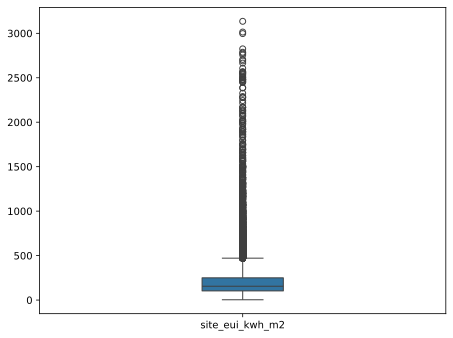

In [151]:
# Boxplot of the target
ax = sns.boxplot(bpd_final_2.dataframe[['site_eui_kwh_m2']], width=0.2)
plt.tight_layout()
plt.savefig(os.path.join(output_path,'exploratory-figures','figure-target-hist.png')) 
plt.savefig(os.path.join(output_path,'exploratory-figures','figure-target-hist.eps'))
plt.show()

As the boxplot hints, there are many values that are above 500 kWh/m<sup>2</sup>/year and are considered outliers. The sheer volume of this data is hinting at a potential data error due to measurement or incorrect input. It could be that these values had an incorrect decimal point in the original value in kBTU, which resulted in an erroneous entry. This is supported in practical evidence, where a typical residential building has  EUI of around 250 kWh/m<sup>2</sup>/year. Let's randomly pick 10 buildings witch such values and examine whether other entries (if there are more), somehow differ. We can validate with other features and/or look at building in the vicinity (e.g. by zipcode).

In [152]:
# pick random 5 buildings with outlier values and display values of 5 random buildings with the same zipcode or city
outliers_ids = unique_buildings[unique_buildings['site_eui_kwh_m2']>=500].sample(5, random_state=4)[['id', 'zip_code', 'city_x']]
random_zip_ids = unique_buildings[unique_buildings['zip_code'].isin(outliers_ids['zip_code'])].sample(5, random_state=4)['id']

In [153]:
# pick random 5 buildings with outlier values and display values of 5 random buildings with the same zipcode or city
bpd_final_2.dataframe[bpd_final_2.dataframe['id'].isin(outliers_ids['id'])][['id', 'year', 'city_x', 'site_eui']+ desc_cols]

id  year      city_x  site_eui  site_eui_kwh_m2 facility_type  \
237426  1019820005  2018    New York  198.7620         627.0127   Multifamily   
237427  1019820005  2019    New York  163.1944         514.8117   Multifamily   
244878  3065760043  2019    Brooklyn  228.7382         721.5755   Multifamily   
244879  3065760043  2020    Brooklyn  230.6422         727.5816   Multifamily   
244880  3065760043  2021    Brooklyn  231.2741         729.5750   Multifamily   
281634  1012700064  2017    New York  262.3636         827.6497     Mixed Use   
281635  1012700064  2018    New York  276.7307         872.9721     Mixed Use   
281636  1012700064  2019    New York  269.1260         848.9823     Mixed Use   
281637  1012700064  2020    New York  216.1293         681.7995     Mixed Use   
281638  1012700064  2021    New York  216.7214         683.6674     Mixed Use   
324752  4057400139  2011  Whitestone  290.0973         915.1382   Multifamily   
324753  4057400139  2012  Whitestone  280.4078         884.5720   Multifamily   
324754  4057400139  2013  Whitestone  288.0610         908.7145   Multifamily   
324755  4057400139  2014  Whitestone  162.3676         512.2032   Multifamily   
324756  4057400139  2015  Whitestone  146.7802         463.0313   Multifamily   
324757  4057400139  2016  Whitestone   93.7777         295.8303   Multifamily   
324758  4057400139  2017  Whitestone   90.1856         284.4988   Multifamily   
324777  4058650030  2011     Bayside  539.1798       1,700.8915   Multifamily   
324782  4058650030  2019     Bayside  121.8017         384.2344   Multifamily   
324783  4058650030  2020     Bayside  112.4579         354.7586   Multifamily   
324784  4058650030  2021     Bayside  112.7660         355.7305   Multifamily   

        year_built  floor_area_m2  energy_star_rating   climate_trimmed  \
237426        1926     2,734.6939              1.0000  4A Mixed - Humid   
237427        1926     2,734.6939              3.0000  4A Mixed - Humid   
244878        1926     2,972.8973              1.0000  4A Mixed - Humid   
244879        1926     2,972.8973              1.0000  4A Mixed - Humid   
244880        1926     2,972.8973              1.0000  4A Mixed - Humid   
281634        1956     2,730.6991             20.0000  4A Mixed - Humid   
281635        1956     2,730.6991                 NaN  4A Mixed - Humid   
281636        1956     2,730.6991                 NaN  4A Mixed - Humid   
281637        1956     2,730.6991                 NaN  4A Mixed - Humid   
281638        1956     2,730.6991                 NaN  4A Mixed - Humid   
324752        1951     9,793.8385              0.0000  4A Mixed - Humid   
324753        1951     9,793.8385              0.0000  4A Mixed - Humid   
324754        1951     9,793.8385                 NaN  4A Mixed - Humid   
324755        1951     9,793.8385             10.0000  4A Mixed - Humid   
324756        1951     9,793.8385             17.0000  4A Mixed - Humid   
324757        1951     9,793.8385             53.0000  4A Mixed - Humid   
324758        1951     9,793.8385             58.0000  4A Mixed - Humid   
324777        1957     4,203.6768              0.0000  4A Mixed - Humid   
324782        1957     4,203.6768              4.0000  4A Mixed - Humid   
324783        1957     4,203.6768              5.0000  4A Mixed - Humid   
324784        1957     4,203.6768              5.0000  4A Mixed - Humid   

        electric_eui_kwh_m2  fuel_eui_kwh_m2  ghg_emissions_m2  population  \
237426             134.8321         492.1804          125.7508 65,840.0000   
237427             104.9807         409.8309          100.7000 65,840.0000   
244878              70.2415         651.3338          135.7260 82,140.0000   
244879              72.7673         654.8142          139.6555 82,140.0000   
244880              72.9666         656.6082          146.0594 82,140.0000   
281634             315.3967         512.2528          189.0423  8,063.0000   
281635             302.4920         

In [154]:
# pick random 5 buildings with outlier values and display values of 5 random buildings with the same zipcode or city
bpd_final_2.dataframe[bpd_final_2.dataframe['id'].isin(random_zip_ids)][['id', 'year', 'city_x', 'site_eui']+ desc_cols]

id  year      city_x  site_eui  site_eui_kwh_m2 facility_type  \
237285  1019167503  2018    New York  119.7896         377.8871   Multifamily   
237286  1019167503  2019    New York  118.4085         373.5302   Multifamily   
237287  1019167503  2020    New York  113.6717         358.5876   Multifamily   
237288  1019167503  2021    New York  113.9831         359.5700   Multifamily   
247170  4045910145  2010  Whitestone   60.5932         191.1466   Multifamily   
247171  4045910145  2011  Whitestone   78.6563         248.1283   Multifamily   
247172  4045910145  2012  Whitestone   49.6291         156.5596   Multifamily   
247173  4045910145  2018  Whitestone   75.9522         239.5981   Multifamily   
247175  4045910145  2020  Whitestone   45.4948         143.5175   Multifamily   
247176  4045910145  2021  Whitestone   45.6195         143.9107   Multifamily   
277919  4045910135  2010  Whitestone   66.2347         208.9432   Multifamily   
277920  4045910135  2011  Whitestone   83.0683         262.0464   Multifamily   
277921  4045910135  2012  Whitestone   49.3921         155.8117   Multifamily   
277922  4045910135  2018  Whitestone   83.8861         264.6264   Multifamily   
277923  4045910135  2019  Whitestone   82.0790         258.9257   Multifamily   
277924  4045910135  2020  Whitestone   75.0043         236.6078   Multifamily   
277925  4045910135  2021  Whitestone   75.2098         237.2560   Multifamily   
290585  3061620049  2018    Brooklyn  261.8134         825.9141   Multifamily   
290586  3061620049  2019    Brooklyn  184.8344         583.0769   Multifamily   
290587  3061620049  2020    Brooklyn  172.5053         544.1837   Multifamily   
290588  3061620049  2021    Brooklyn  172.9779         545.6746   Multifamily   
299033  1019500057  2010    New York   89.2618         281.5845   Multifamily   
299034  1019500057  2011    New York   75.6596         238.6750   Multifamily   
299035  1019500057  2012    New York   74.6312         235.4308   Multifamily   
299036  1019500057  2013    New York   77.0855         243.1732   Multifamily   
299037  1019500057  2014    New York   72.6819         229.2816   Multifamily   
299038  1019500057  2015    New York   73.0296         230.3784   Multifamily   
299039  1019500057  2016    New York   75.8938         239.4139   Multifamily   
299040  1019500057  2017    New York   78.8084         248.6082   Multifamily   
299041  1019500057  2018    New York   89.1361         281.1880   Multifamily   
299042  1019500057  2019    New York   91.5491         288.8000   Multifamily   
299043  1019500057  2020    New York   85.0321         268.2414   Multifamily   
299044  1019500057  2021    New York   85.2650         268.9763   Multifamily   

        year_built  floor_area_m2  energy_star_rating   climate_trimmed  \
237285        2015    13,923.6573             25.0000  4A Mixed - Humid   
237286        2015    13,923.6573             24.0000  4A Mixed - Humid   
237287        2015    13,923.6573             25.0000  4A Mixed - Humid   
237288        2015    13,923.6573             25.0000  4A Mixed - Humid   
247170        1958     4,044.9984              0.0000  4A Mixed - Humid   
247171        1958     4,044.9984              0.0000  4A Mixed - Humid   
247172        1958     4,044.9984              0.0000  4A Mixed - Humid   
247173        1958     4,044.9984             65.0000  4A Mixed - Humid   
247175        1958     4,044.9984             89.0000  4A Mixed - Humid   
247176        1958     4,044.9984             89.0000  4A Mixed - Humid   
277919        1958     4,044.9984              0.0000  4A Mixed - Humid   
277920        1958     4,044.9984              0.0000  4A Mixed - Humid   
277921        1958     4,044.9984              0.0000  4A Mixed - Humid   
277922        1958     4,044.9984             47.0000  4A Mixed - Humid   
277923        1958     4,044.9984             40.0000  4A Mixed - Humid   
277924        1958     4,044.9984             43.0000  4A Mix

### Check distributions & Representativeness

In [155]:
%config InlineBackend.figure_format = 'svg'

### Site EUI

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


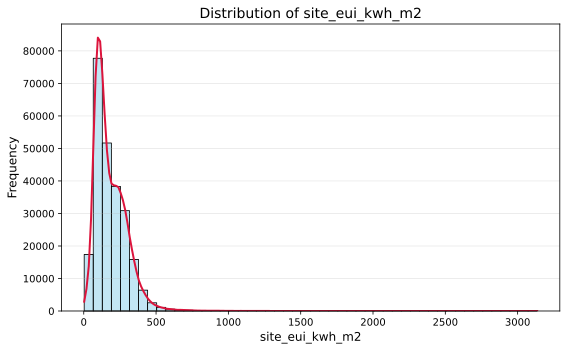

In [205]:
# Target
plot_distribution(bpd_final_2.dataframe, 'site_eui_kwh_m2', bins=50)

### Commentary
The distribution is clearly not normal – it resembles a power distribution, but it is likely log-normal, so let's transform the data with log<sub>10</sub> transformation.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


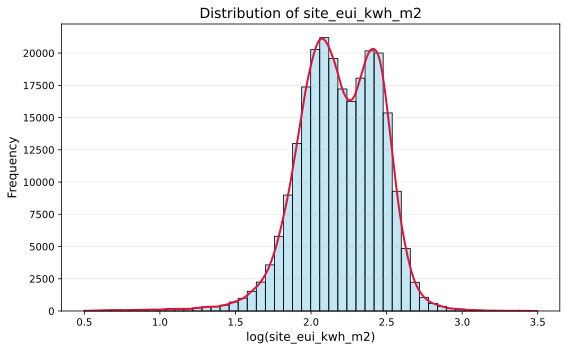

In [206]:
# Log-normal
plot_distribution(np.log10(bpd_final_2.dataframe[['site_eui_kwh_m2']]), 'site_eui_kwh_m2', bins=50, x_label='log(site_eui_kwh_m2)')

### Commentary
The transformation shows a bimodial distribution, likely caused by a mixture of two distributions. It is possible that there are two populations — high and low energy-intensive buildings — and we need to uncover the latent variables that can help us distinguish between them if it is possible. This will probably cause problems with prediction, depending on which variables have the strongest effect. If there are two populations with two distinct effects of e.g. <code>floor_area_m2</code>, then we will see erroneous predictions. Let's test where these distributions differ. Although there is an overlap, let's analyse some descriptive statistics.

In [207]:
Dataset(bpd_final_2.dataframe[np.log10(bpd_final_2.dataframe['site_eui_kwh_m2'])<2.3][desc_cols]).analyse_data()

variable  vartype  q_NaN   p_NaN   count  \
0          site_eui_kwh_m2  float64      0   0.00%  151935   
1            facility_type   object      0   0.00%  151935   
2               year_built    Int64    763   0.50%  151172   
3            floor_area_m2  float64      0   0.00%  151935   
4       energy_star_rating  float64  80217  52.80%   71718   
5          climate_trimmed   object      0   0.00%  151935   
6      electric_eui_kwh_m2  float64  16360  10.77%  135575   
7          fuel_eui_kwh_m2  float64  21211  13.96%  130724   
8         ghg_emissions_m2  float64  13555   8.92%  138380   
9               population  float64    298   0.20%  151637   
10  electricity_fuel_ratio  float64  34913  22.98%  117022   
11          age_floor_area  Float64    763   0.50%  151172   
12                   age_2    Int64    763   0.50%  151172   
13    energy_star_rating_2  float64  80217  52.80%   71718   

                    mean                median            mode  \
0               115.5573              113.4013         86.7512   
1   categorical variable  categorical variable     Residential   
2             1,978.1401            1,983.0000            2000   
3             7,200.0106            2,410.1836         89.1869   
4                77.0678               86.0000        100.0000   
5   categorical variable  categorical variable  2A Hot - Humid   
6                63.8413               60.0125          0.0000   
7                52.4342               47.0354          0.0000   
8                35.5966               34.5396          8.0383   
9            35,479.2035           29,172.0000     28,058.0000   
10              378.8969                1.1670          0.0000   
11          271,018.4109           42,958.6444          0.0000   
12            2,208.7462            1,089.0000            1225   
13            6,591.7899            7,396.0000     10,000.0000   

                     std               minimum               maximum  unique  
0                41.8075                3.1546              199.5256  136254  
1   categorical variable  categorical variable  categorical variable       6  
2                27.4411                  1649                  2022     169  
3            13,100.9468               47.0089          182,908.1555   18721  
4                25.5412                0.0000              100.0000     101  
5   categorical variable  categorical variable  categorical variable       9  
6                28.3962                0.0000              198.8723  125480  
7                37.8506                0.0000              225.4726  106734  
8                14.3841                0.6331              118.2399  128239  
9            18,952.9809               36.0000          116,469.0000    1280  
10           55,927.7187                0.0000       11,168,814.2954  108147  
11          614,978.0250                0.0000       17,694,312.9984   98127  
12            3,222.6834                     0                138384     188  
13            3,042.6731                0.0000           10,000.0000     101

In [208]:
Dataset(bpd_final_2.dataframe[np.log10(bpd_final_2.dataframe['site_eui_kwh_m2'])>2.3][desc_cols]).analyse_data()

variable  vartype  q_NaN   p_NaN  count  \
0          site_eui_kwh_m2  float64      0   0.00%  91880   
1            facility_type   object      0   0.00%  91880   
2               year_built    Int64    277   0.30%  91603   
3            floor_area_m2  float64      0   0.00%  91880   
4       energy_star_rating  float64  15507  16.88%  76373   
5          climate_trimmed   object      0   0.00%  91880   
6      electric_eui_kwh_m2  float64   5222   5.68%  86658   
7          fuel_eui_kwh_m2  float64   7744   8.43%  84136   
8         ghg_emissions_m2  float64   2493   2.71%  89387   
9               population  float64    207   0.23%  91673   
10  electricity_fuel_ratio  float64  10568  11.50%  81312   
11          age_floor_area  Float64    277   0.30%  91603   
12                   age_2    Int64    277   0.30%  91603   
13    energy_star_rating_2  float64  15507  16.88%  76373   

                    mean                median              mode  \
0               300.6436              276.4551          292.1122   
1   categorical variable  categorical variable       Multifamily   
2             1,950.2489            1,942.0000              1928   
3            10,933.5955            6,289.5358        4,645.1520   
4                40.0735               40.0000            0.0000   
5   categorical variable  categorical variable  4A Mixed - Humid   
6                73.2702               57.3712            0.0000   
7               226.8480              215.5310            0.0000   
8                68.9680               63.3877           70.9310   
9            55,403.1125           56,114.0000       99,776.0000   
10                6.2934                0.2494            0.0000   
11          621,300.2805          424,663.5120      214,384.9132   
12            5,418.7368            5,184.0000              8100   
13            2,480.7233            1,600.0000            0.0000   

                     std               minimum               maximum  unique  
0               114.8194              199.5274            3,134.9954   88877  
1   categorical variable  categorical variable  categorical variable       6  
2                30.6499                  1649                  2020     161  
3            15,001.0776               48.3096          185,617.2081   13834  
4                29.5778                0.0000              100.0000     101  
5   categorical variable  categorical variable  categorical variable       9  
6                60.9571                0.0000            2,456.4792   83889  
7               103.9274                0.0000            2,953.8937   81058  
8                27.6077               28.5302              886.2828   86575  
9            25,885.3317               28.0000          116,469.0000     673  
10              619.7989                0.0000          150,163.4447   78736  
11          824,658.7753                0.0000       17,859,680.4096   77939  
12            4,021.5406                     0                134689     203  
13            2,580.6113                0.0000           10,000.0000     101

### Total Energy 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


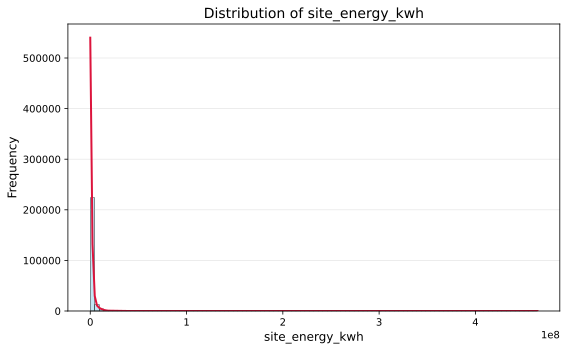

In [209]:
plot_distribution(bpd_final_2.dataframe, 'site_energy_kwh', bins=100, save=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


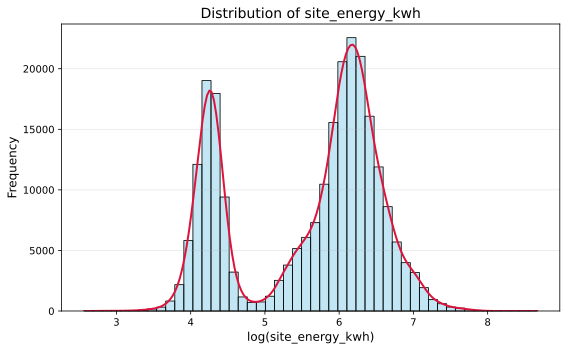

In [210]:
# Log-normal
plot_distribution(np.log10(bpd_final_2.dataframe[['site_energy_kwh']]), 'site_energy_kwh', bins=50, x_label='log(site_energy_kwh)', save=True)

In [211]:
Dataset(bpd_final_2.dataframe[np.log10(bpd_final_2.dataframe['site_energy_kwh'])<5][desc_cols + ['site_energy_kwh']]).analyse_data()

variable  vartype  q_NaN   p_NaN  count  \
0          site_eui_kwh_m2  float64      0   0.00%  73795   
1            facility_type   object      0   0.00%  73795   
2               year_built    Int64     47   0.06%  73748   
3            floor_area_m2  float64      0   0.00%  73795   
4       energy_star_rating  float64  72761  98.60%   1034   
5          climate_trimmed   object      0   0.00%  73795   
6      electric_eui_kwh_m2  float64   2154   2.92%  71641   
7          fuel_eui_kwh_m2  float64   5100   6.91%  68695   
8         ghg_emissions_m2  float64    927   1.26%  72868   
9               population  float64     13   0.02%  73782   
10  electricity_fuel_ratio  float64   7403  10.03%  66392   
11          age_floor_area  Float64     47   0.06%  73748   
12                   age_2    Int64     47   0.06%  73748   
13    energy_star_rating_2  float64  72761  98.60%   1034   
14         site_energy_kwh  float64      0   0.00%  73795   

                    mean                median            mode  \
0               112.9375              107.2430         39.4324   
1   categorical variable  categorical variable     Residential   
2             1,982.2599            1,983.0000            1975   
3               255.9455              160.5365         89.1869   
4                93.2863              100.0000        100.0000   
5   categorical variable  categorical variable  2A Hot - Humid   
6                65.1693               60.8023          0.0000   
7                49.1129               44.9742          0.0000   
8                41.9920               39.6047          0.7181   
9            27,425.2675           28,058.0000     28,058.0000   
10                3.2416                1.3206          0.0000   
11            9,953.5642            4,352.3216      4,280.9721   
12            1,160.3372              900.0000            1849   
13            9,120.4352           10,000.0000     10,000.0000   
14           20,065.4650           17,864.3517     40,199.0347   

                     std               minimum               maximum  unique  
0                47.6944                3.1546              529.7871   73535  
1   categorical variable  categorical variable  categorical variable       6  
2                15.2059                  1830                  2020     124  
3               742.0278               47.0089           23,187.7627    3744  
4                20.4576                0.0000              100.0000      42  
5   categorical variable  categorical variable  categorical variable       7  
6                29.6704                0.0000              484.0373   71376  
7                29.7337                0.0000              370.8750   63756  
8                17.6949                0.6331              260.5365   72774  
9            10,682.0557              504.0000          102,553.0000     256  
10               48.4212                0.0000           10,770.5065   66336  
11           47,015.1689                0.0000        2,084,325.0391   34519  
12            1,328.6105                     0                 33856     129  
13            2,212.5408                0.0000           10,000.0000      42  
14           11,609.9592              368.0082           99,955.8522   73669

In [212]:
Dataset(bpd_final_2.dataframe[np.log10(bpd_final_2.dataframe['site_energy_kwh'])>=5][desc_cols + ['site_energy_kwh']]).analyse_data()

variable  vartype  q_NaN   p_NaN   count  \
0          site_eui_kwh_m2  float64      0   0.00%  170020   
1            facility_type   object      0   0.00%  170020   
2               year_built    Int64    993   0.58%  169027   
3            floor_area_m2  float64      0   0.00%  170020   
4       energy_star_rating  float64  22963  13.51%  147057   
5          climate_trimmed   object      0   0.00%  170020   
6      electric_eui_kwh_m2  float64  19428  11.43%  150592   
7          fuel_eui_kwh_m2  float64  23855  14.03%  146165   
8         ghg_emissions_m2  float64  15121   8.89%  154899   
9               population  float64    492   0.29%  169528   
10  electricity_fuel_ratio  float64  38078  22.40%  131942   
11          age_floor_area  Float64    993   0.58%  169027   
12                   age_2    Int64    993   0.58%  169027   
13    energy_star_rating_2  float64  22963  13.51%  147057   
14         site_energy_kwh  float64      0   0.00%  170020   

                    mean                median              mode  \
0               216.7163              205.7298           86.7512   
1   categorical variable  categorical variable       Multifamily   
2             1,961.2272            1,963.0000              1928   
3            12,231.6484            7,026.2569        4,645.1520   
4                57.7410               65.0000            0.0000   
5   categorical variable  categorical variable  4A Mixed - Humid   
6                68.6354               58.0990            0.0000   
7               154.3918              150.2752            0.0000   
8                51.8456               49.8733           70.9310   
9            49,758.3787           47,019.0000       96,918.0000   
10              338.2986                0.3761            0.0000   
11          574,756.1594          370,344.2193            0.0000   
12            4,405.8085            3,025.0000              8100   
13            4,438.9573            4,225.0000            0.0000   
14        2,552,817.1945        1,484,455.9685   13,848,580.0768   

                     std               minimum               maximum  unique  
0               126.3948                3.3953            3,134.9954  151785  
1   categorical variable  categorical variable  categorical variable       6  
2                34.7827                  1649                  2022     180  
3            15,363.3845              165.5532          185,617.2081   23123  
4                33.2406                0.0000              100.0000     101  
5   categorical variable  categorical variable  categorical variable       9  
6                49.7262                0.0000            2,456.4792  137980  
7               119.1349                0.0000            2,953.8937  123907  
8                28.9268                0.7116              886.2828  142040  
9            24,829.5935               28.0000          116,469.0000    1295  
10           52,673.0624                0.0000       11,168,814.2954  120547  
11          806,434.9096                0.0000       17,859,680.4096  135764  
12            4,190.5446                     0                138384     217  
13            3,469.4132                0.0000           10,000.0000     101  
14        4,234,370.9101          100,008.8486      464,443,088.0307  156360

### Floor Area

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


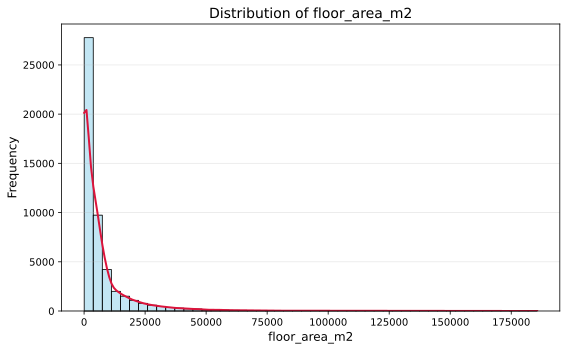

In [213]:
# Floor area
plot_distribution(unique_buildings, 'floor_area_m2', bins=50, save=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


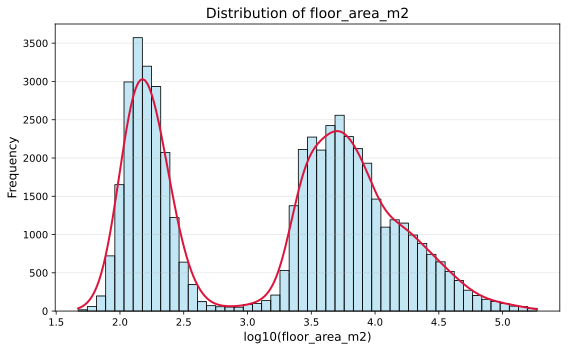

In [214]:
plot_distribution(np.log10(unique_buildings[['floor_area_m2']]), 'floor_area_m2', bins=50, x_label='log10(floor_area_m2)', save=True)

### Commentary
The same effect is even more present in <code>floor_area</code>. The transformation shows distinct a bimodial distribution, probably in the same way as for <code>site_eui_kwh_m2</code>. Let's see if the grouping by <code>facility_type</code> reveals any more insights.

In [215]:
# code
Dataset(unique_buildings[np.log10(unique_buildings['floor_area_m2'])<3][desc_cols]).analyse_data()

variable  vartype  q_NaN   p_NaN  count  \
0          site_eui_kwh_m2  float64      0   0.00%  20008   
1            facility_type   object      0   0.00%  20008   
2               year_built    Int64     11   0.05%  19997   
3            floor_area_m2  float64      0   0.00%  20008   
4       energy_star_rating  float64  19986  99.89%     22   
5          climate_trimmed   object      0   0.00%  20008   
6      electric_eui_kwh_m2  float64    443   2.21%  19565   
7          fuel_eui_kwh_m2  float64   1805   9.02%  18203   
8         ghg_emissions_m2  float64     21   0.10%  19987   
9               population  float64      2   0.01%  20006   
10  electricity_fuel_ratio  float64   2519  12.59%  17489   
11          age_floor_area  Float64     11   0.05%  19997   
12                   age_2    Int64     11   0.05%  19997   
13    energy_star_rating_2  float64  19986  99.89%     22   

                    mean                median            mode  \
0               129.3413              121.0870         72.8668   
1   categorical variable  categorical variable     Residential   
2             1,982.0938            1,981.0000            1968   
3               176.6474              155.9842         89.1869   
4                55.9545               57.0000        100.0000   
5   categorical variable  categorical variable  2A Hot - Humid   
6                72.5890               67.4748         46.5890   
7                60.0866               55.9503          0.0000   
8                48.3462               45.4779         17.8214   
9            26,886.8191           28,058.0000     28,058.0000   
10                2.7718                1.1738          0.2282   
11            4,986.9944            4,162.0562      3,170.3162   
12            1,043.1304              900.0000            1296   
13            4,429.4091            3,249.0000     10,000.0000   

                     std               minimum               maximum  unique  
0                66.1904                3.7355            3,014.1430   20006  
1   categorical variable  categorical variable  categorical variable       4  
2                14.0848                  1898                  2017      98  
3                90.5017               47.0089              998.7077    3281  
4                36.8827                0.0000              100.0000      18  
5   categorical variable  categorical variable  categorical variable       6  
6                34.8058                0.0077            1,614.9522   19561  
7                45.8185                0.0000            2,953.8937   17732  
8                21.0374                0.6919              599.1981   19985  
9            10,057.3434              504.0000           96,918.0000      80  
10               20.9459                0.0007            1,271.1025   17487  
11            5,177.1487              358.2341          113,155.9027   13849  
12              970.6682                     1                 14400     102  
13            3,932.8264                0.0000           10,000.0000      18

In [216]:
# code
Dataset(unique_buildings[np.log10(unique_buildings['floor_area_m2'])>3][desc_cols]).analyse_data()

variable  vartype  q_NaN   p_NaN  count  \
0          site_eui_kwh_m2  float64      0   0.00%  30294   
1            facility_type   object      0   0.00%  30294   
2               year_built    Int64    227   0.75%  30067   
3            floor_area_m2  float64      0   0.00%  30294   
4       energy_star_rating  float64   4134  13.65%  26160   
5          climate_trimmed   object      0   0.00%  30294   
6      electric_eui_kwh_m2  float64   3367  11.11%  26927   
7          fuel_eui_kwh_m2  float64   3806  12.56%  26488   
8         ghg_emissions_m2  float64   2393   7.90%  27901   
9               population  float64    113   0.37%  30181   
10  electricity_fuel_ratio  float64   7195  23.75%  23099   
11          age_floor_area  Float64    227   0.75%  30067   
12                   age_2    Int64    227   0.75%  30067   
13    energy_star_rating_2  float64   4134  13.65%  26160   

                    mean                median              mode  \
0               218.7342              195.1928          292.1122   
1   categorical variable  categorical variable       Multifamily   
2             1,962.9437            1,965.0000              1920   
3            12,010.6470            6,279.2236        4,645.1520   
4                49.3794               54.0000            0.0000   
5   categorical variable  categorical variable  4A Mixed - Humid   
6                69.9776               57.9872            0.0000   
7               153.8467              132.6923            0.0000   
8                52.3466               48.7192           70.9310   
9            50,078.7046           46,816.0000       99,776.0000   
10              476.3453                0.3990            0.0000   
11          502,349.6473          304,339.9539            0.0000   
12            4,087.9943            2,500.0000                 1   
13            3,896.6786            2,916.0000            0.0000   

                     std               minimum               maximum  unique  
0               153.3897                3.1546            3,134.9954   30213  
1   categorical variable  categorical variable  categorical variable       6  
2                36.1983                  1649                  2022     180  
3            16,722.3579            1,003.3528          185,617.2081   23106  
4                38.1891                0.0000              100.0000     101  
5   categorical variable  categorical variable  categorical variable       9  
6                58.4576                0.0000            2,456.4792   26803  
7               142.7893                0.0000            2,922.9135   23845  
8                35.4809                0.7116              886.2828   27839  
9            24,593.3379               28.0000          116,469.0000    1293  
10           50,647.6298                0.0000        7,497,554.6483   23006  
11          839,878.4607                0.0000       16,536,741.1200   27984  
12            4,160.3544                     0                130321     174  
13            3,750.7972                0.0000           10,000.0000     101

In [217]:
%config InlineBackend.figure_format = 'png'

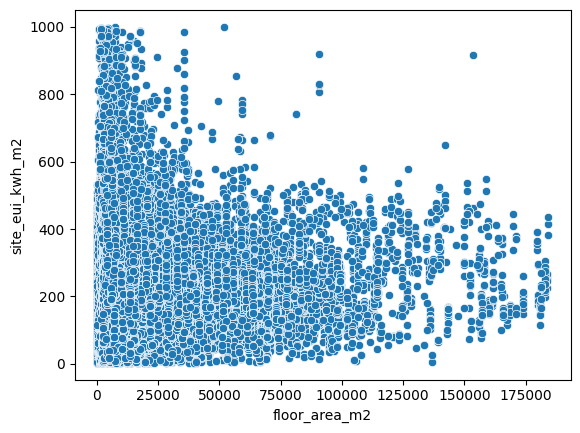

In [218]:
ax = sns.scatterplot(x=bpd_final_2.dataframe[bpd_final_2.dataframe['site_eui_kwh_m2']<1000]['floor_area_m2'],
                     y=bpd_final_2.dataframe[bpd_final_2.dataframe['site_eui_kwh_m2']<1000]['site_eui_kwh_m2'])

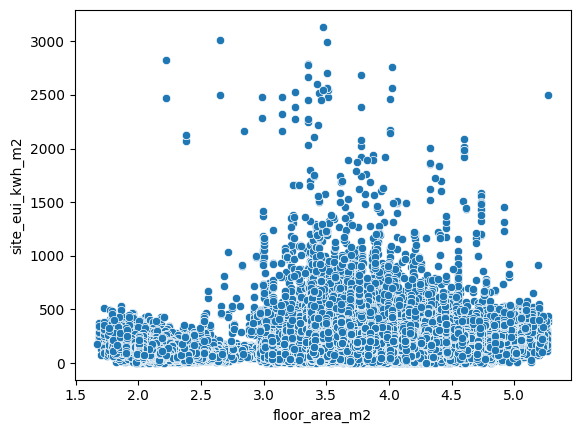

In [219]:
ax = sns.scatterplot(x=np.log10(bpd_final_2.dataframe['floor_area_m2']), y=bpd_final_2.dataframe['site_eui_kwh_m2'])

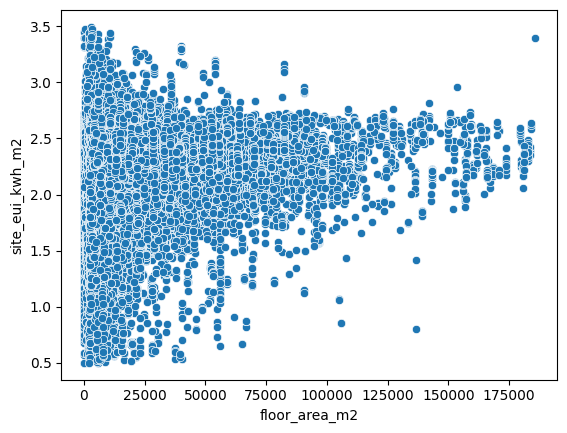

In [220]:
ax = sns.scatterplot(x=bpd_final_2.dataframe['floor_area_m2'], y=np.log10(bpd_final_2.dataframe['site_eui_kwh_m2']))

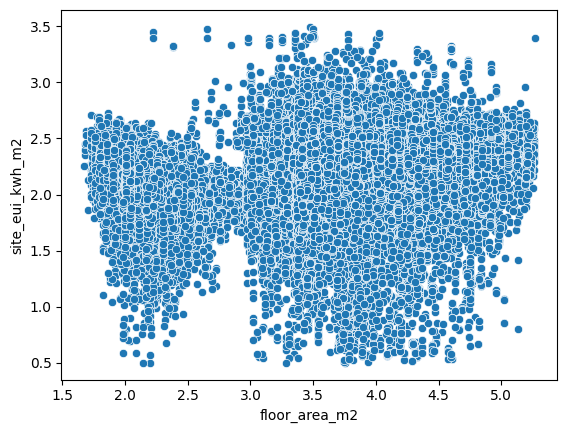

In [221]:
ax = sns.scatterplot(x=np.log10(bpd_final_2.dataframe['floor_area_m2']), y=np.log10(bpd_final_2.dataframe['site_eui_kwh_m2']))

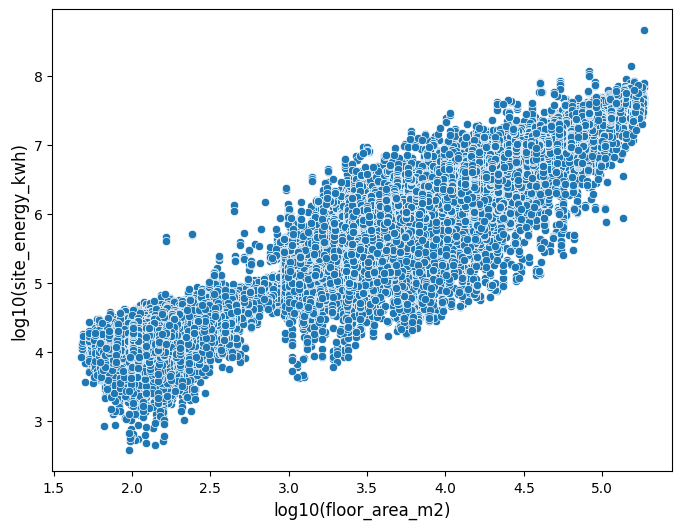

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(
    x=np.log10(bpd_final_2.dataframe['floor_area_m2']),
    y=np.log10(bpd_final_2.dataframe['site_energy_kwh']),
    ax=ax
)
plt.xlabel('log10(floor_area_m2)', fontsize=12)
plt.ylabel('log10(site_energy_kwh)', fontsize=12)

plt.savefig(os.path.join(output_path,'exploratory-figures','figure-scatter-log-floor-area-energy.png')) 
plt.savefig(os.path.join(output_path,'exploratory-figures','figure-scatter-log-floor-area-energy.eps'))

### Year Built

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


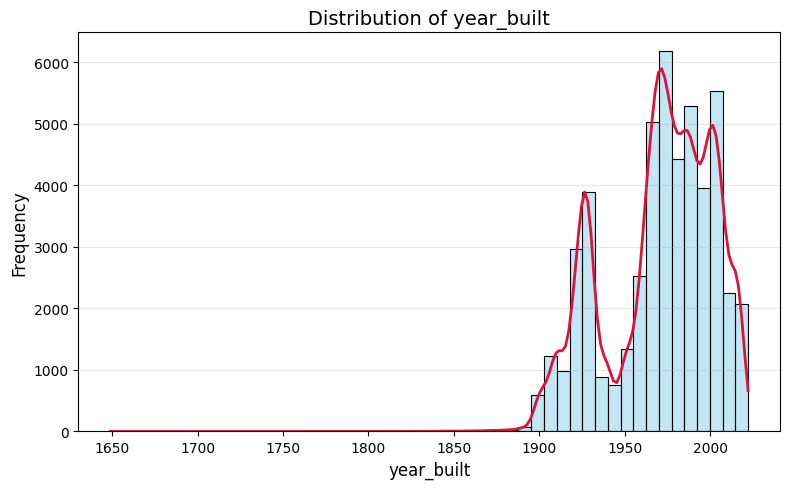

In [223]:
# Year built
plot_distribution(unique_buildings, 'year_built', bins=50, save=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


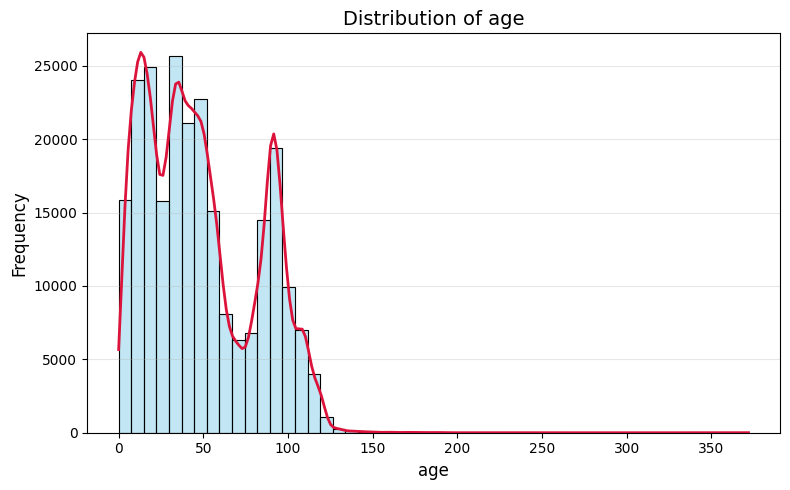

In [224]:
# Age
plot_distribution(bpd_final_2.dataframe, 'age', bins=50, save=True)

### Commentary
<code>Age</code> and <code>year_built</code> are almost identical reversed variables. While <code>year_built</code> stays fixed, <code>age</code> takes a value of <code>year</code> - <code>year_built</code>. The time value is not too significant to change the distribution. We can see a bimodial distribution again, this time caused by a boom of building in-between the war period. The age structure of the data can indicate and help predict some variance in EUI, but without the information on the building material and renovation efforts, the prediction power of this variable is limited. We can test this assumption with a simple scatter plot.

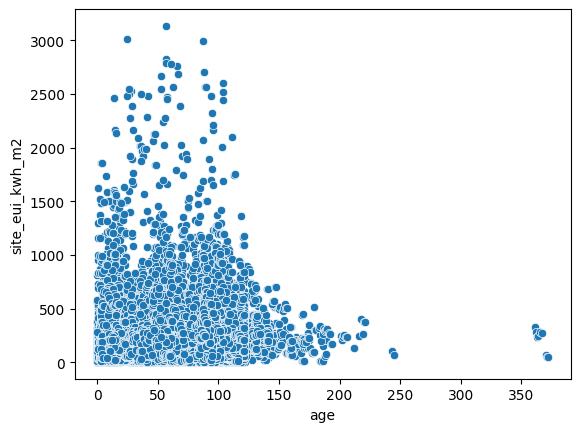

In [225]:
# scatter plot of age and EUI
ax = sns.scatterplot(x=bpd_final_2.dataframe['age'], y=bpd_final_2.dataframe['site_eui_kwh_m2'])

### Population

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


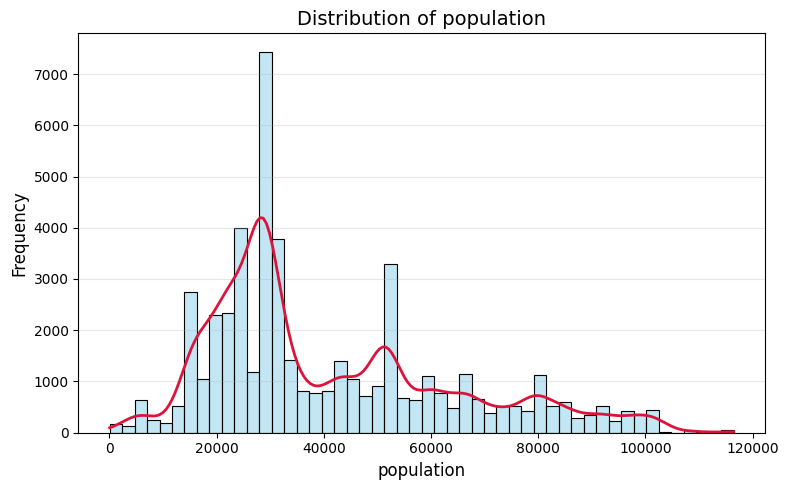

In [226]:
# Population
plot_distribution(unique_buildings, 'population', bins=50, save=True)

### Commentary
The <code>population</code> distribution is quite scattered but almost forming something resembling a uniform distribution (if we ignore some spikes). However, there is little expectation that population severly affects EUI. Although there might be some heat gains from densely populated areas, these are probably marginal without knowing all latent variables that impact the EUI. 

### Energy Star Rating

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


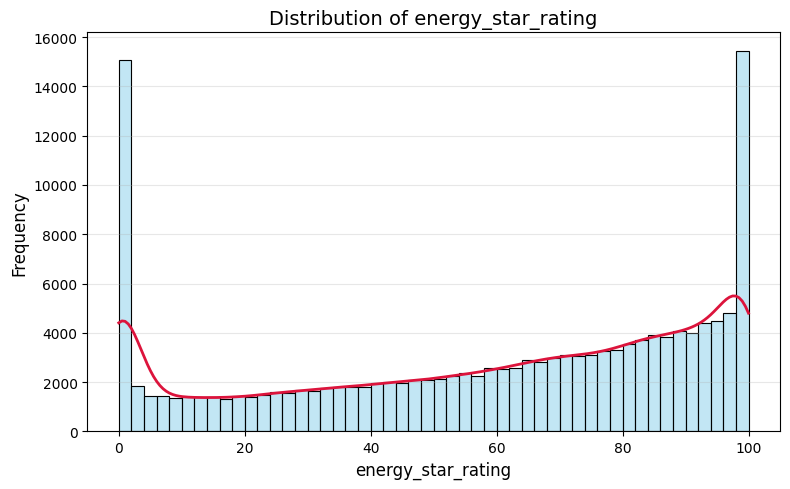

In [227]:
# Energy star rating
plot_distribution(bpd_final_2.dataframe, 'energy_star_rating', bins=50, save=True)

### Commentary
The distribution of <code>energy_star_rating</code>, a type of voluntary benchmarking of the U.S. building stock reveals interesting insights. Since the purpose of the score is to benchmark the building against comparable peers, one could expect a normal distribution, if the benchmarking goal is to rank in the population. However, it could follow another distribution, if the goal is to simply compare the performance against a static benchmark that does not depend on a dynamic variable in a given category. We see that:
* There are big spikes on 0 and 100
    * 0-spike just means missing data
    * 100-spike is more *interesting* since it points to a sampling bias – better scoring buildings are more likely to be in the database, which is a data problem
* The score linearly increases with the density. This can also be a sampling bias but it can be a methodological flaw in the rating's design.

### Climates

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


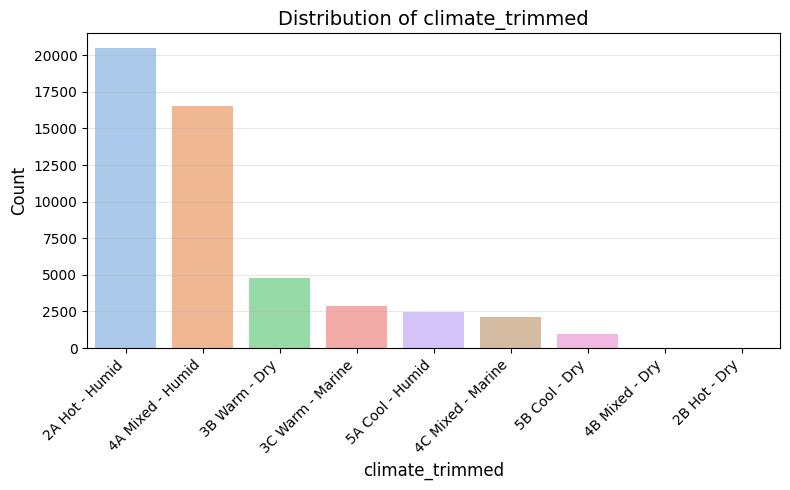

In [228]:
# Climates
plot_distribution(unique_buildings, 'climate_trimmed', save=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


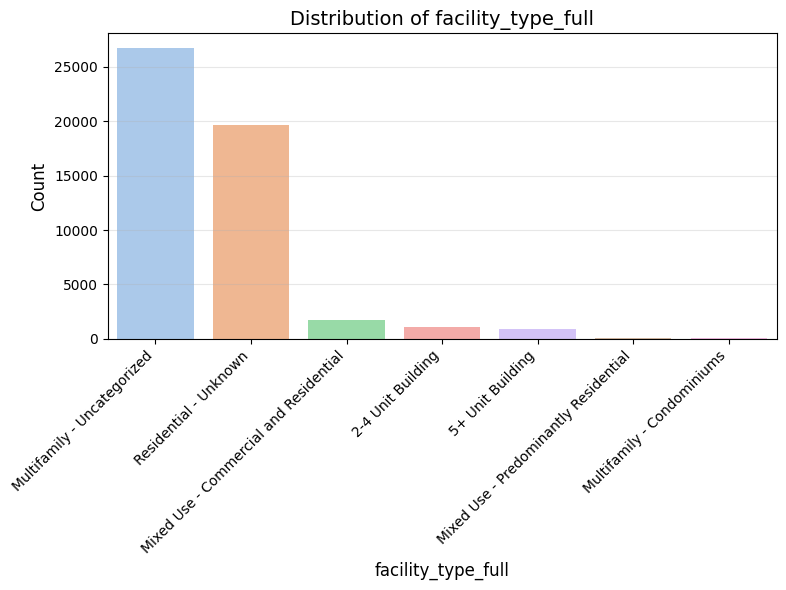

In [229]:
plot_distribution(unique_buildings, 'facility_type_full', figsize=(8,6) ,top_n=7, save=True)

### Commentary


Facility types and climates indicate that the sample isn't representative, especially by <code>facility_type</code>. The literature review has shown that the majority of assets are single homes in the US. However, these can be hidden under <code>Residential - Other</code>, because some studies claim that the BPD dataset is representative of the building stock.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


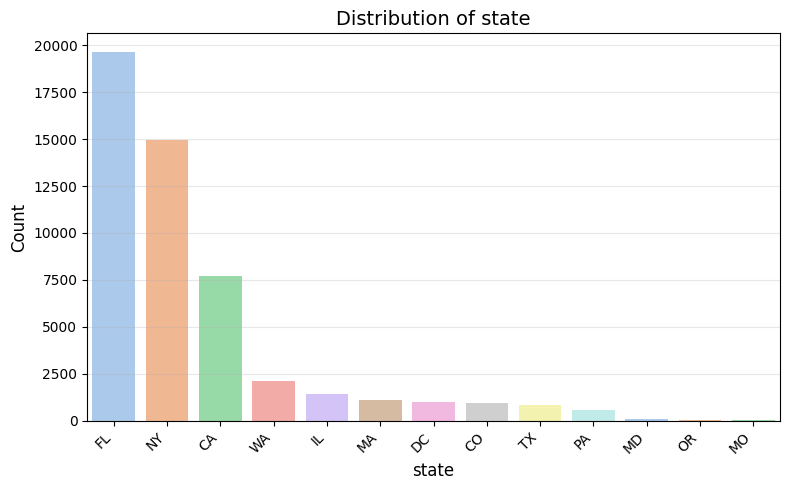

In [33]:
# States
plot_distribution(unique_buildings, 'state_x', x_label='state' ,save=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


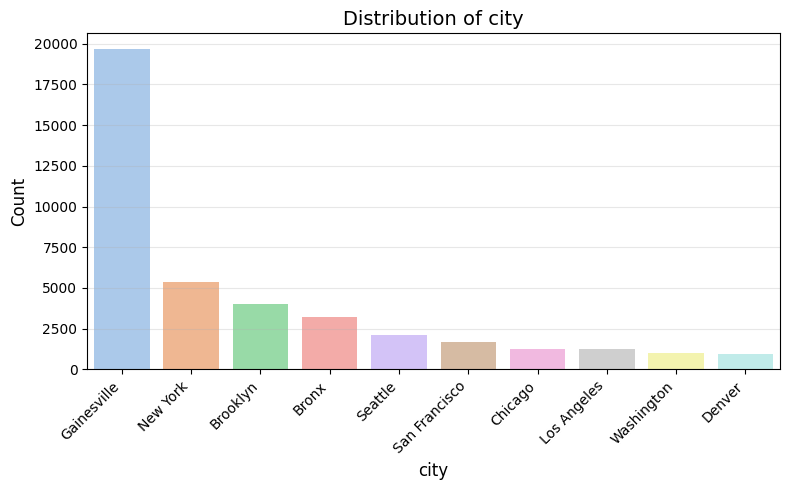

In [35]:
# Cities
plot_distribution(unique_buildings, 'city_x', x_label='city', top_n=10, save=True)

### Commentary
The same can be seen in the distribution of cities and states. Majority of buildings are located in Gainesville, Florida. This is a distinct climate, so the external validity can be affected by the model being too reliant on hot-humid environment conditions. This can be remedied as the sample is quite large and also through dummy variables.

## Principal Components Analysis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


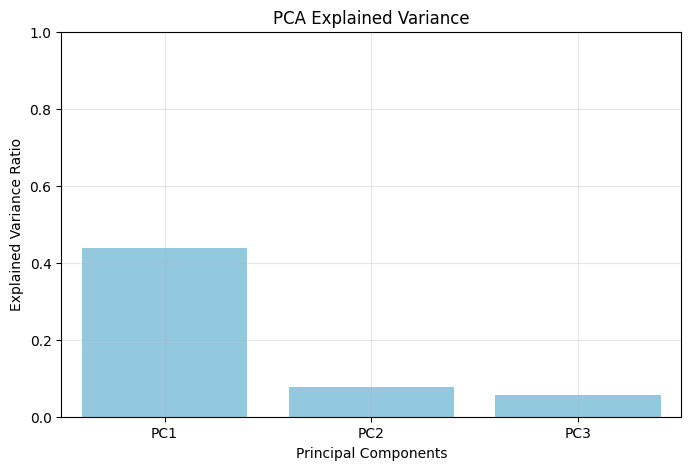

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


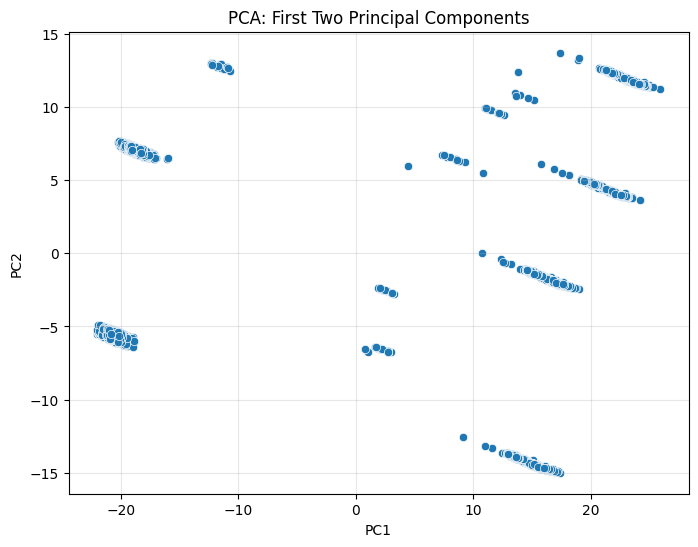

In [232]:
# Run pca analysis through the function defined above
pca_result, pca_model = run_pca(bpd_final_2.dataframe, n_components=3, plot_variance=True, plot_components=True, save=True)

In [233]:
loadings = pd.DataFrame(pca_model.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pca_model.n_components_)],
                        index=bpd_final_2.dataframe.select_dtypes(include=np.number).columns.tolist())

In [234]:
# Absolute value to find strongest contributors
top_n = 15  # number of top features per PC
for pc in loadings.columns:
    print(f"\nTop features contributing to {pc}:")
    print(loadings[pc].abs().sort_values(ascending=False).head(top_n))


Top features contributing to PC1:
8_DP10   0.0510
8_DP01   0.0510
4_HDSD   0.0509
8_DX90   0.0508
3_HDSD   0.0508
6_RHMX   0.0508
5_HDSD   0.0507
4_CLDD   0.0507
2_HDSD   0.0507
6_HDSD   0.0507
1_HDSD   0.0507
1_HTDD   0.0506
1_TMAX   0.0506
4_DX90   0.0506
1_TAVG   0.0506
Name: PC1, dtype: float64

Top features contributing to PC2:
2_WDF2    0.1114
4_WDF5    0.1111
10_WDF5   0.1078
2_WDF5    0.1076
5_DYHF    0.1061
4_WDF2    0.1059
10_WDF2   0.1033
1_DP1X    0.1033
10_DYHF   0.1004
9_WDF2    0.0991
5_WDF5    0.0988
7_WDF2    0.0963
9_WDF5    0.0957
1_EMXP    0.0954
4_DYHF    0.0893
Name: PC2, dtype: float64

Top features contributing to PC3:
11_EMSD   0.1369
11_DSND   0.1354
9_AWBT    0.1293
12_ASLP   0.1266
10_DYTS   0.1242
6_WDF2    0.1240
11_EMXP   0.1180
2_ASLP    0.1167
11_DP1X   0.1135
6_WDF5    0.1112
5_DYXP    0.1085
1_ASLP    0.1025
12_RHMX   0.1023
3_WDF2    0.1021
10_EMXP   0.0998
Name: PC3, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


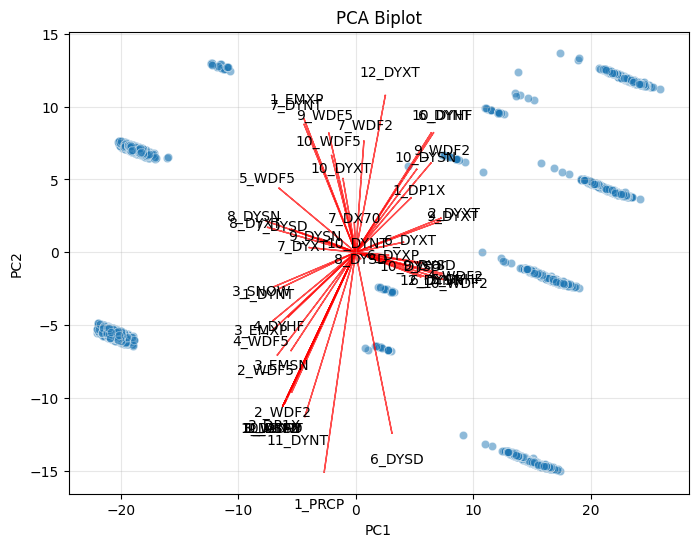

In [235]:
# Compute loading magnitudes
loading_magnitude = np.sqrt(pca_model.components_[0,:]**2 + pca_model.components_[1,:]**2)

# Pick top N features
top_n = 50
top_features_idx = np.argsort(loading_magnitude)[-top_n:]
top_features = [bpd_final_2.dataframe.select_dtypes(include=np.number).columns.tolist()[i] for i in top_features_idx]

# Plot biplot with only these arrows
pca_biplot(pca_result, pca_model, top_features, scale=150, save=True)

### Commentary

The PCA Analysis shows very strong clustering based on the climate variables. The biplot shows a handful of distinct clusters and underlying variables. This means that the predictive model might benefit from the reduction of weather features as they're linearly dependent. Just two principal components can reduce the number of features significantly, reducing overfitting and computation demands. However, it might be interesting to see PCA on variables other than weather features.

### Numerical relationships (scatter plots)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


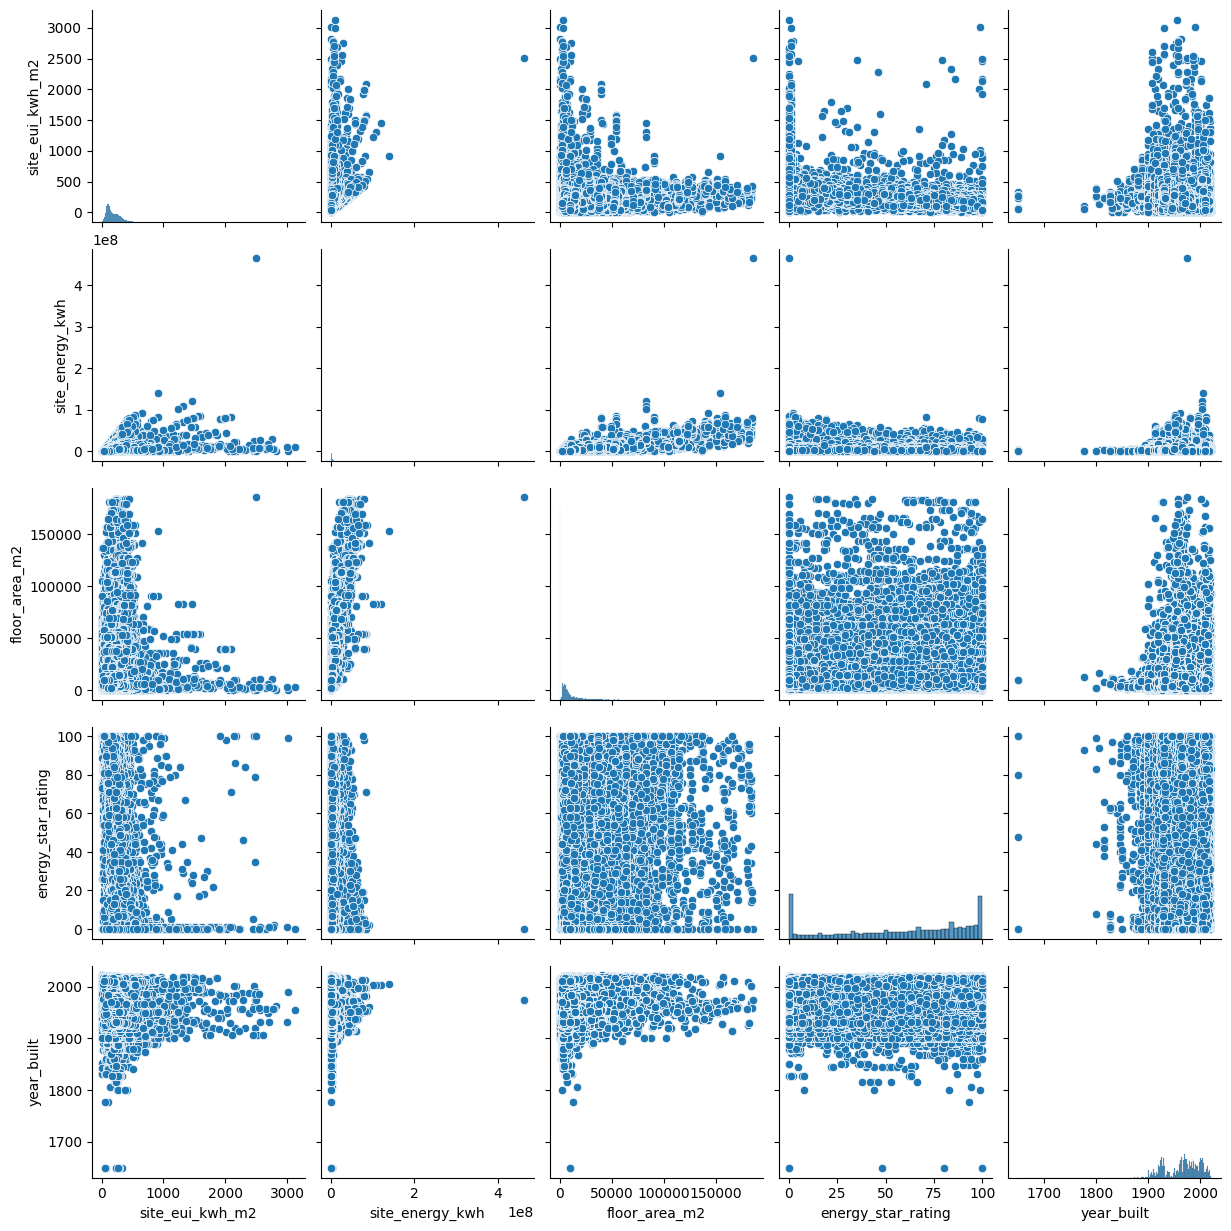

In [236]:
%config InlineBackend.figure_format = 'png'
cols = ['site_eui_kwh_m2','site_energy_kwh','floor_area_m2','energy_star_rating','year_built']
g = sns.pairplot(bpd_final_2.dataframe[cols])
g.savefig(os.path.join(output_path,'exploratory-figures','figure-pairplot.png')) 
g.savefig(os.path.join(output_path,'exploratory-figures','figure-pairplot.eps')) 

### Commentary
Pairwise scatter plots do not reveal significant or unexpected relationships. Also, obvious outliers are destroying the scale of some charts. 

In [237]:
%config InlineBackend.figure_format = 'svg'

### Correlations

In [238]:
corr_cols = bpd_final_2.dataframe.loc[:, ~bpd_final_2.dataframe.columns.str.contains('feature', case=False)].select_dtypes(include=np.number).columns.tolist()
corr_drop = ['year', 'zip_code', 'county_code', 'latitude', 'longitude']
corr_cols = [e for e in corr_cols if e not in corr_drop]
corr_matrix = bpd_final_2.dataframe[corr_cols].corr()

In [239]:
corr_matrix[abs(corr_matrix['site_eui_kwh_m2'])>=0.3][['site_eui_kwh_m2']].sort_values('site_eui_kwh_m2', ascending=False)

site_eui_kwh_m2
site_eui_kwh_m2                1.0000
site_eui                       1.0000
fuel_eui                       0.9269
fuel_eui_kwh_m2                0.9269
ghg_emissions_int              0.9013
ghg_emissions_m2               0.9013
1_HTDD                         0.5346
3_AWND                         0.5122
2_HTDD                         0.5047
1_AWND                         0.4983
2_DT32                         0.4977
3_HDSD                         0.4971
2_AWND                         0.4962
1_DT32                         0.4956
1_HDSD                         0.4953
4_HDSD                         0.4950
2_HDSD                         0.4944
12_AWND                        0.4897
5_HDSD                         0.4863
3_HTDD                         0.4861
6_HDSD                         0.4821
10_AWND                        0.4736
12_HTDD                        0.4634
1_DX32                         0.4596
4_AWND                         0.4577
4_HTDD                         0.4447
11_AWND                        0.4427
11_HTDD                        0.4382
3_DT32                         0.4342
4_WSF5                         0.4283
12_HDSD                        0.4263
1_WSF5                         0.4161
4_DP01                         0.4127
12_DT32                        0.4116
9_AWND                         0.4039
4_WSF2                         0.3928
1_WSF2                         0.3878
11_HDSD                        0.3777
age                            0.3756
site_energy_kBTU               0.3711
site_energy_kwh                0.3711
2_DX32                         0.3703
9_ASLP                         0.3694
4_DP10                         0.3635
electric_eui                   0.3509
electric_eui_kwh_m2            0.3509
2_WSF2                         0.3503
age_2                          0.3501
10_WSF5                        0.3483
10_DP01                        0.3451
5_DP01                         0.3429
1_DSNW                         0.3390
11_WSF5                        0.3373
population                     0.3358
3_WSF5                         0.3340
10_HTDD                        0.3318
10_WSF2                        0.3291
12_WSF5                        0.3276
11_WSF2                        0.3225
1_SNOW                         0.3222
log_floor_area                 0.3204
10_DP10                        0.3189
2_WSF5                         0.3189
10_PRCP                        0.3124
10_DP1X                        0.3102
3_DX32                         0.3056
1_EMSN                         0.3038
12_DX32                        0.3026
4_PRCP                         0.3014
3_WSF2                         0.3009
9_CDSD                        -0.3005
7_CDSD                        -0.3016
9_DYHF                        -0.3028
10_AWBT                       -0.3058
9_EMNT                        -0.3082
5_ADPT                        -0.3108
11_RHAV                       -0.3131
12_DYFG                       -0.3139
8_EMXT                        -0.3140
10_CDSD                       -0.3200
8_TMAX                        -0.3207
11_CDSD                       -0.3221
12_CDSD                       -0.3236
1_RHAV                        -0.3239
5_DX70                        -0.3241
5_TAVG                        -0.3264
12_RHAV                       -0.3296
12_CLDD                       -0.3306
9_TAVG                        -0.3311
7_DX90                        -0.3390
2_RHMX                        -0.3423
5_CLDD                        -0.3435
5_DX90                        -0.3453
3_RHAV                        -0.3461
12_EMNT                       -0.3486
5_AWBT                        -0.3487
6_CDSD                        -0.3502
3_CDSD                        -0.3505
4_RHMX                        -0.3597
12_DYHF                       -0.3618
5_TMAX                        -0.3642
4_EMXT                        -0.3646
11_DYFG                       -0.3647
year_built                    -0.3680
5_CDSD                        -0

In [240]:
corr_matrix[abs(corr_matrix['site_eui_kwh_m2'])>=0.3][['site_eui_kwh_m2']].sort_values('site_eui_kwh_m2', ascending=False).shape

(172, 1)

### Commentary 
There are some interesting correlations. Apart from the obvious variables like <code>fuel_eui</code> and <code>ghg_emissions
</code>, several climate variables, also depending on the month are strongly to moderately correlated with <code>
site_eui</code>, such as heating and cooling degree days, temperature, wind, precipitation and running sum variables (e.g. heating degree days to date).

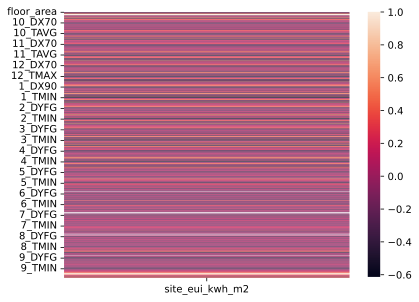

In [241]:
ax = sns.heatmap(corr_matrix[['site_eui_kwh_m2']])

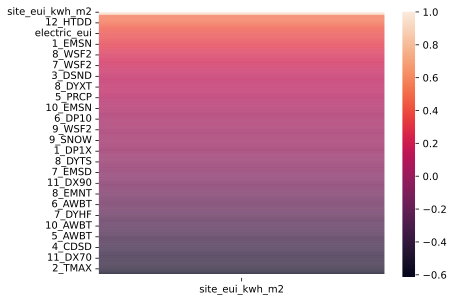

In [251]:
ax = sns.heatmap(corr_matrix[['site_eui_kwh_m2']].sort_values(by='site_eui_kwh_m2',ascending=False))
fig = ax.get_figure()
plt.savefig(os.path.join(output_path,'exploratory-figures','figure-corr-heatmap.png'), bbox_inches="tight") 
plt.savefig(os.path.join(output_path,'exploratory-figures','figure-corr-heatmap.eps'), bbox_inches="tight")

In [243]:
corr_matrix[abs(corr_matrix['site_eui_kwh_m2'])>=0.3][['site_eui_kwh_m2']].sort_values('site_eui_kwh_m2', ascending=False)

site_eui_kwh_m2
site_eui_kwh_m2                1.0000
site_eui                       1.0000
fuel_eui                       0.9269
fuel_eui_kwh_m2                0.9269
ghg_emissions_int              0.9013
ghg_emissions_m2               0.9013
1_HTDD                         0.5346
3_AWND                         0.5122
2_HTDD                         0.5047
1_AWND                         0.4983
2_DT32                         0.4977
3_HDSD                         0.4971
2_AWND                         0.4962
1_DT32                         0.4956
1_HDSD                         0.4953
4_HDSD                         0.4950
2_HDSD                         0.4944
12_AWND                        0.4897
5_HDSD                         0.4863
3_HTDD                         0.4861
6_HDSD                         0.4821
10_AWND                        0.4736
12_HTDD                        0.4634
1_DX32                         0.4596
4_AWND                         0.4577
4_HTDD                         0.4447
11_AWND                        0.4427
11_HTDD                        0.4382
3_DT32                         0.4342
4_WSF5                         0.4283
12_HDSD                        0.4263
1_WSF5                         0.4161
4_DP01                         0.4127
12_DT32                        0.4116
9_AWND                         0.4039
4_WSF2                         0.3928
1_WSF2                         0.3878
11_HDSD                        0.3777
age                            0.3756
site_energy_kBTU               0.3711
site_energy_kwh                0.3711
2_DX32                         0.3703
9_ASLP                         0.3694
4_DP10                         0.3635
electric_eui                   0.3509
electric_eui_kwh_m2            0.3509
2_WSF2                         0.3503
age_2                          0.3501
10_WSF5                        0.3483
10_DP01                        0.3451
5_DP01                         0.3429
1_DSNW                         0.3390
11_WSF5                        0.3373
population                     0.3358
3_WSF5                         0.3340
10_HTDD                        0.3318
10_WSF2                        0.3291
12_WSF5                        0.3276
11_WSF2                        0.3225
1_SNOW                         0.3222
log_floor_area                 0.3204
10_DP10                        0.3189
2_WSF5                         0.3189
10_PRCP                        0.3124
10_DP1X                        0.3102
3_DX32                         0.3056
1_EMSN                         0.3038
12_DX32                        0.3026
4_PRCP                         0.3014
3_WSF2                         0.3009
9_CDSD                        -0.3005
7_CDSD                        -0.3016
9_DYHF                        -0.3028
10_AWBT                       -0.3058
9_EMNT                        -0.3082
5_ADPT                        -0.3108
11_RHAV                       -0.3131
12_DYFG                       -0.3139
8_EMXT                        -0.3140
10_CDSD                       -0.3200
8_TMAX                        -0.3207
11_CDSD                       -0.3221
12_CDSD                       -0.3236
1_RHAV                        -0.3239
5_DX70                        -0.3241
5_TAVG                        -0.3264
12_RHAV                       -0.3296
12_CLDD                       -0.3306
9_TAVG                        -0.3311
7_DX90                        -0.3390
2_RHMX                        -0.3423
5_CLDD                        -0.3435
5_DX90                        -0.3453
3_RHAV                        -0.3461
12_EMNT                       -0.3486
5_AWBT                        -0.3487
6_CDSD                        -0.3502
3_CDSD                        -0.3505
4_RHMX                        -0.3597
12_DYHF                       -0.3618
5_TMAX                        -0.3642
4_EMXT                        -0.3646
11_DYFG                       -0.3647
year_built                    -0.3680
5_CDSD                        -0

In [244]:
corr_matrix[abs(corr_matrix['site_eui_kwh_m2'])<0.3][['site_eui_kwh_m2']].sort_values('site_eui_kwh_m2', ascending=False).shape

(367, 1)

### Analyse EUI across states

In [245]:
bpd_final_2.dataframe.groupby('state_x')['site_eui_kwh_m2'].describe().map(lambda x: f"{x:.2f}")

count    mean     std    min     25%     50%     75%      max
state_x                                                                  
CA       39192.00  127.13   82.77   3.15   85.53  115.77  148.92  1762.24
CO        5401.00  197.61   93.00  26.18  144.86  183.91  232.59  2825.06
DC       12500.00  190.12   83.77   4.52  133.96  178.91  234.66  1065.71
FL       71569.00  115.00   46.39   3.16   84.14  108.38  137.82   529.79
IL        8941.00  228.90  108.95   3.96  164.94  214.77  273.92  2756.78
MA        3105.00  236.46  183.90   3.49  153.19  209.04  283.82  3014.14
MD         166.00  323.92  293.64   8.04  142.85  233.70  384.05  1693.15
MO          30.00  270.27  153.34  18.21  109.38  258.84  426.66   507.80
NY       86153.00  271.49  120.04   3.39  211.33  264.32  321.19  3135.00
OR          65.00  362.25  272.86  50.79  172.24  273.82  458.99  1340.39
PA        1983.00  200.00  135.73   3.22  122.64  174.85  240.93  1630.75
TX        1612.00  108.76   31.48  10.71   87.28  109.51  130.52   215.93
WA       13098.00  129.48  111.35   9.23   82.99  101.28  140.41  2531.32

In [246]:
bpd_final_2.dataframe.groupby('climate_trimmed')['site_eui_kwh_m2'].describe().map(lambda x: f"{x:.2f}")

count    mean     std    min     25%     50%     75%  \
climate_trimmed                                                               
2A Hot - Humid      73181.00  114.86   46.13   3.16   84.24  108.40  137.56   
2B Hot - Dry           40.00  114.40   61.23  20.40   77.64  114.04  179.04   
3B Warm - Dry       22809.00  118.08   61.75   3.15   85.90  113.88  142.00   
3C Warm - Marine    16245.00  139.86  104.22   3.15   84.74  119.62  164.79   
4A Mixed - Humid   100832.00  260.08  120.36   3.22  195.80  253.63  312.96   
4B Mixed - Dry         76.00  133.75   64.07  30.64   74.34  139.44  167.67   
4C Mixed - Marine   13163.00  130.63  113.87   9.23   83.04  101.47  141.17   
5A Cool - Humid     12046.00  230.85  132.42   3.49  162.48  213.55  276.33   
5B Cool - Dry        5423.00  197.28   93.07   8.97  144.56  183.71  232.55   

                       max  
climate_trimmed             
2A Hot - Humid      529.79  
2B Hot - Dry        212.02  
3B Warm - Dry      1762.24  
3C Warm - Marine   1488.33  
4A Mixed - Humid   3135.00  
4B Mixed - Dry      286.37  
4C Mixed - Marine  2531.32  
5A Cool - Humid    3014.14  
5B Cool - Dry      2825.06

In [247]:
counties = bpd_final_2.dataframe.groupby(['county','state_x','climate_trimmed'])['site_eui_kwh_m2'].describe().sort_values(by='state_x')
counties[counties['count']>=200].map(lambda x: f"{x:.2f}")

count    mean     std  \
county                state_x climate_trimmed                               
Orange County         CA      3B Warm - Dry       2847.00  122.20   69.65   
Riverside County      CA      3B Warm - Dry        769.00  108.36   58.87   
Sacramento County     CA      3B Warm - Dry        918.00  122.92   49.77   
San Bernardino County CA      3B Warm - Dry        840.00  118.23   66.55   
San Diego County      CA      3B Warm - Dry       1939.00  101.12   67.12   
San Francisco County  CA      3C Warm - Marine   10994.00  151.30  113.30   
San Mateo County      CA      3C Warm - Marine     735.00  116.84   91.55   
Santa Clara County    CA      3C Warm - Marine    2189.00  123.06   78.84   
Solano County         CA      3B Warm - Dry        238.00  135.72   56.69   
Ventura County        CA      3C Warm - Marine     316.00  110.50  146.02   
Fresno County         CA      3B Warm - Dry        202.00   98.80   64.01   
Contra Costa County   CA      3B Warm - Dry        656.00  113.98   39.98   
Los Angeles County    CA      3B Warm - Dry      13364.00  119.32   60.78   
Alameda County        CA      3C Warm - Marine    1305.00  109.44   45.20   
Denver County         CO      5B Cool - Dry       5145.00  198.84   93.83   
District of Columbia  DC      4A Mixed - Humid   12500.00  190.12   83.77   
Alachua County        FL      2A Hot - Humid     71563.00  115.00   46.39   
Cook County           IL      5A Cool - Humid     8941.00  228.90  108.95   
Suffolk County        MA      5A Cool - Humid     3064.00  237.01  184.92   
Bronx County          NY      4A Mixed - Humid   17055.00  293.89  114.94   
Kings County          NY      4A Mixed - Humid   20802.00  255.96  116.41   
Queens County         NY      4A Mixed - Humid   13388.00  275.40  127.96   
Richmond County       NY      4A Mixed - Humid     740.00  265.08  138.62   
New York County       NY      4A Mixed - Humid   33677.00  269.11  118.90   
Philadelphia County   PA      4A Mixed - Humid    1979.00  200.10  135.81   
Travis County         TX      2A Hot - Humid      1557.00  109.17   31.38   
King County           WA      4C Mixed - Marine  13098.00  129.48  111.35   

                                                   min     25%     50%  \
county                state_x climate_trimmed                            
Orange County         CA      3B Warm - Dry       3.20   88.82  110.23   
Riverside County      CA      3B Warm - Dry       3.27   63.44  107.27   
Sacramento County     CA      3B Warm - Dry       3.92   95.38  126.05   
San Bernardino County CA      3B Warm - Dry      10.41   75.27  115.17   
San Diego County      CA      3B Warm - Dry       3.34   70.26   96.11   
San Francisco County  CA      3C Warm - Marine    3.15   84.86  126.83   
San Mateo County      CA      3C Warm - Marine    4.74   79.22  107.28   
Santa Clara County    CA      3C Warm - Marine    3.87   90.98  115.23   
Solano County         CA      3B Warm - Dry      36.09  110.00  130.84   
Ventura County        CA      3C Warm - Marine    9.24   54.69  105.99   
Fresno County         CA      3B Warm - Dry       3.19   47.84  101.81   
Contra Costa County   CA      3B Warm - Dry      12.62   83.55  117.01   
Los Angeles County    CA      3B Warm - Dry       3.15   88.59  115.48   
Alameda County        CA      3C Warm - Marine    3.40   83.46  110.41   
Denver County         CO      5B Cool - Dry      26.18  146.66  184.39   
District of Columbia  DC      4A Mixed - Humid    4.52  133.96  178.91   
Alachua County        FL      2A Hot - Humid      3.16   84.14  108.37   
Cook County           IL      5A Cool - Humid     3.96  164.94  214.77   
Suffolk County        MA      5A Cool - Humid     3.49  153.27  209.19   
Bronx County          NY      4A Mixed - Humid    4.19  237.91  292.33   
Kings County          NY      4A Mixed - Humid    3.53  202.70  255.28   
Queens County         NY      4A Mixed - Humid    3.39  217.36  267.88   
Richmond County       NY      4A Mixed - H

In [248]:
cities = bpd_final_2.dataframe.groupby(['city_x','climate_trimmed'])['site_eui_kwh_m2'].describe()
cities[cities['count']>=500].map(lambda x: f"{x:.2f}")

count    mean     std    min     25%  \
city_x           climate_trimmed                                              
Astoria          4A Mixed - Humid    1038.00  279.49  197.14   8.97  212.28   
Austin           2A Hot - Humid      1602.00  108.81   31.46  10.71   87.35   
Boston           5A Cool - Humid     2262.00  236.94  193.28   3.49  154.83   
Bronx            4A Mixed - Humid   17055.00  293.89  114.94   4.19  237.91   
Brooklyn         4A Mixed - Humid   21183.00  254.79  116.73   3.53  200.71   
Chicago          5A Cool - Humid     8733.00  228.78  109.60   3.96  164.47   
Denver           5B Cool - Dry       5225.00  199.08   93.65  26.18  146.77   
Elmhurst         4A Mixed - Humid     898.00  280.19   89.16  17.40  246.46   
Flushing         4A Mixed - Humid    2156.00  279.40  121.34   4.03  224.54   
Forest Hills     4A Mixed - Humid    1288.00  273.08   89.82  28.49  226.35   
Gainesville      2A Hot - Humid     71563.00  115.00   46.39   3.16   84.14   
Irvine           3B Warm - Dry        643.00  123.25   87.92  28.11   89.66   
Jackson Heights  4A Mixed - Humid     933.00  284.24  100.83  11.15  229.48   
Jamaica          4A Mixed - Humid    1052.00  286.68  104.28   9.41  232.91   
Long Island City 4A Mixed - Humid     727.00  224.84  133.08   5.07  163.14   
Los Angeles      3B Warm - Dry       5149.00  115.94   66.85   3.15   86.51   
New York         4A Mixed - Humid   33704.00  269.16  119.01   4.08  206.81   
North Hollywood  3B Warm - Dry        689.00  123.44   37.30   4.88  110.62   
Philadelphia     4A Mixed - Humid    1979.00  200.10  135.81   3.22  122.64   
Rego Park        4A Mixed - Humid     637.00  256.81   74.73   6.00  221.23   
San Diego        3B Warm - Dry        932.00   95.66   55.95   3.34   66.64   
San Francisco    3C Warm - Marine   10998.00  151.30  113.28   3.15   84.88   
San Jose         3C Warm - Marine     903.00  127.06   98.08   3.87   88.91   
Seattle          4C Mixed - Marine  13098.00  129.48  111.35   9.23   82.99   
Staten Island    4A Mixed - Humid     740.00  265.08  138.62  22.36  180.10   
Sunnyside        4A Mixed - Humid     503.00  273.02   76.45  44.13  227.12   
Van Nuys         3B Warm - Dry        571.00  133.31   51.79   3.59  105.72   
Washington       4A Mixed - Humid   12500.00  190.12   83.77   4.52  133.96   
Woodside         4A Mixed - Humid     568.00  277.19  109.62   3.39  224.40   

                                       50%     75%      max  
city_x           climate_trimmed                             
Astoria          4A Mixed - Humid   273.51  324.07  2996.79  
Austin           2A Hot - Humid     109.64  130.51   215.93  
Boston           5A Cool - Humid    208.91  281.05  3014.14  
Bronx            4A Mixed - Humid   292.33  349.60  2075.71  
Brooklyn         4A Mixed - Humid   254.29  304.81  3135.00  
Chicago          5A Cool - Humid    214.41  273.16  2756.78  
Denver           5B Cool - Dry      184.66  234.23  2825.06  
Elmhurst         4A Mixed - Humid   285.66  324.17   812.16  
Flushing         4A Mixed - Humid   278.49  326.98  1861.17  
Forest Hills     4A Mixed - Humid   264.62  319.08  1229.79  
Gainesville      2A Hot - Humid     108.37  137.81   529.79  
Irvine           3B Warm - Dry      101.24  124.56   706.05  
Jackson Heights  4A Mixed - Humid   276.18  324.67  1199.55  
Jamaica          4A Mixed - Humid   281.12  328.77  1200.49  
Long Island City 4A Mixed - Humid   210.77  260.94  1277.78  
Los Angeles      3B Warm - Dry      110.22  136.61  1350.70  
New York         4A Mixed - Humid   255.09  314.35  2787.12  
North Hollywood  3B Warm - Dry      128.81  143.46   255.20  
Philadelphia     4A Mixed - Humid   174.68  240.98  1630.75  
Rego Park        4A Mixed - Humid   249.31  292.09   668.37  
San Diego        3B Warm - Dry       89.97  112.41   867.82  
San Francisco    3C Warm - Marine   126.82  184.07  1414.83  
San Jose         3C Warm - Marine   113.47  139.94  1004.61  
Seattle          4C Mixed - Marine  101

### Map with energy intensity

In [249]:
# Example: assume df has columns ['latitude', 'longitude', 'site_energy_eui_kwh_m2']
map_data = bpd_final_2.dataframe[bpd_final_2.dataframe['site_eui_kwh_m2']<=500]

# 1. Aggregate data by coordinates
agg = (
    map_data.groupby(['latitude', 'longitude'], as_index=False)
      ['site_eui_kwh_m2']
      .mean()
)

# 2. Initialize map centered on your data
m = folium.Map(location=[agg['latitude'].mean(), agg['longitude'].mean()],
               zoom_start=4, tiles='CartoDB positron')

# 3. Normalize color scale
min_val, max_val = agg['site_eui_kwh_m2'].min(), agg['site_eui_kwh_m2'].max()

def color_scale(val):
    """Convert value to color on blue–red scale."""
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    norm = colors.Normalize(vmin=min_val, vmax=max_val)
    cmap = cm.get_cmap('RdYlGn_r')  # red = high EUI, green = low
    rgb = cmap(norm(val))[:3]
    return f'#{int(rgb[0]*255):02x}{int(rgb[1]*255):02x}{int(rgb[2]*255):02x}'

# 4. Add circle markers
for _, row in agg.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        color=color_scale(row['site_eui_kwh_m2']),
        fill=True,
        fill_color=color_scale(row['site_eui_kwh_m2']),
        fill_opacity=0.7,
        popup=folium.Popup(f"EUI: {row['site_eui_kwh_m2']:.1f} kWh/m²", max_width=150)
    ).add_to(m)

# 5. Add legend (optional)
from branca.colormap import LinearColormap
colormap = LinearColormap(
    colors=['green', 'yellow', 'red'],
    vmin=min_val,
    vmax=max_val,
    caption='Average site_eui_kwh_m2'
)
colormap.add_to(m)

m

/var/folders/7v/dnk02cnn1mn21wh5kpl09cbc0000gn/T/ipykernel_63421/1701135039.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn_r')  # red = high EUI, green = low
